<a href="https://colab.research.google.com/github/desstaw/Shortcut_Learning/blob/main/Birds_dynamic_left_patch_alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install opencv-python-headless

In [ ]:
# Upload Kaggle API key
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"despinat","key":"b646bd9e35ac4cadddb11e6ca630354a"}'}

In [ ]:
# Move the Kaggle API key to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Download the dataset using Kaggle API
!kaggle datasets download -d wenewone/cub2002011


Dataset URL: https://www.kaggle.com/datasets/wenewone/cub2002011
License(s): CC0-1.0
 99% 1.48G/1.49G [00:23<00:00, 73.0MB/s]
100% 1.49G/1.49G [00:23<00:00, 68.0MB/s]


In [ ]:
# Unzip the dataset
!unzip cub2002011.zip -d cub2002011


Streaming output truncated to the last 5000 lines.
  inflating: cub2002011/segmentations/116.Chipping_Sparrow/Chipping_Sparrow_0109_108162.png  
  inflating: cub2002011/segmentations/116.Chipping_Sparrow/Chipping_Sparrow_0110_108974.png  
  inflating: cub2002011/segmentations/116.Chipping_Sparrow/Chipping_Sparrow_0111_108515.png  
  inflating: cub2002011/segmentations/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0001_110632.png  
  inflating: cub2002011/segmentations/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0002_110606.png  
  inflating: cub2002011/segmentations/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0003_110672.png  
  inflating: cub2002011/segmentations/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0005_110911.png  
  inflating: cub2002011/segmentations/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0008_110536.png  
  inflating: cub2002011/segmentations/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0009_797256.png  
  inflating: cub2002011/segmentations/117.Clay_colored_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import random
import shutil
import numpy as np
from PIL import Image
import pandas as pd
import cv2
from collections import Counter

# Paths to the dataset and output folders on Google Drive
dataset_path = 'cub2002011/CUB_200_2011/images'
segmentation_path = '/content/cub2002011/segmentations'
output_path_landbirds = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/data/landbirds'
output_path_waterbirds = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/data/waterbirds'
cub_wb_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_wb'

# Create directories if they don't exist
os.makedirs(output_path_landbirds, exist_ok=True)
os.makedirs(output_path_waterbirds, exist_ok=True)
os.makedirs(cub_wb_path, exist_ok=True)

# Load necessary files
classes_file = '/content/cub2002011/CUB_200_2011/classes.txt'
images_file = '/content/cub2002011/CUB_200_2011/images.txt'
train_test_split_file = '/content/cub2002011/CUB_200_2011/train_test_split.txt'
image_class_labels_file = '/content/cub2002011/CUB_200_2011/image_class_labels.txt'

# Load classes (species) file
classes_df = pd.read_csv(classes_file, sep=' ', header=None, names=['class_id', 'species_name'])

# Load images file
images_df = pd.read_csv(images_file, sep=' ', header=None, names=['image_id', 'file_path'])

# Load train/test split file
train_test_split_df = pd.read_csv(train_test_split_file, sep=' ', header=None, names=['image_id', 'is_training_image'])

# Load image class labels file
image_class_labels_df = pd.read_csv(image_class_labels_file, sep=' ', header=None, names=['image_id', 'class_id'])

# Merge dataframes to have all the necessary information
merged_df = pd.merge(images_df, image_class_labels_df, on='image_id')
merged_df = pd.merge(merged_df, train_test_split_df, on='image_id')
merged_df = pd.merge(merged_df, classes_df, on='class_id')

# Define waterbird and landbird species based on their class IDs (from classes.txt)
waterbird_species = [
    '001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross',
    '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet',
    '008.Rhinoceros_Auklet', '021.Eastern_Towhee', '023.Brandt_Cormorant',
    '024.Red_faced_Cormorant', '025.Pelagic_Cormorant', '044.Frigatebird',
    '045.Northern_Fulmar', '046.Gadwall', '050.Eared_Grebe', '051.Horned_Grebe',
    '052.Pied_billed_Grebe', '053.Western_Grebe', '058.Pigeon_Guillemot',
    '059.California_Gull', '060.Glaucous_winged_Gull', '061.Heermann_Gull',
    '062.Herring_Gull', '063.Ivory_Gull', '064.Ring_billed_Gull', '065.Slaty_backed_Gull',
    '066.Western_Gull', '071.Long_tailed_Jaeger', '072.Pomarine_Jaeger',
    '084.Red_legged_Kittiwake', '086.Pacific_Loon', '087.Mallard',
    '088.Western_Meadowlark', '089.Hooded_Merganser', '090.Red_breasted_Merganser',
    '100.Brown_Pelican', '101.White_Pelican', '102.Western_Wood_Pewee',
    '106.Horned_Puffin', '141.Artic_Tern', '142.Black_Tern', '143.Caspian_Tern',
    '144.Common_Tern', '145.Elegant_Tern', '146.Forsters_Tern', '147.Least_Tern'
]

landbird_species = [
    '004.Groove_billed_Ani', '009.Brewer_Blackbird', '010.Red_winged_Blackbird',
    '011.Rusty_Blackbird', '012.Yellow_headed_Blackbird', '013.Bobolink',
    '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting',
    '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird', '020.Yellow_breasted_Chat',
    '022.Chuck_will_Widow', '026.Bronzed_Cowbird', '027.Shiny_Cowbird',
    '028.Brown_Creeper', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo',
    '032.Mangrove_Cuckoo', '033.Yellow_billed_Cuckoo', '034.Gray_crowned_Rosy_Finch',
    '035.Purple_Finch', '036.Northern_Flicker', '037.Acadian_Flycatcher',
    '038.Great_Crested_Flycatcher', '039.Least_Flycatcher', '040.Olive_sided_Flycatcher',
    '041.Scissor_tailed_Flycatcher', '042.Vermilion_Flycatcher', '043.Yellow_bellied_Flycatcher',
    '047.American_Goldfinch', '048.European_Goldfinch', '049.Boat_tailed_Grackle',
    '070.House_Finch', '073.Purple_Gallinule', '074.American_Goldfinch',
    '075.Common_Grackle', '076.Crested_Caracara', '077.Gray_Jay', '078.Blue_Jay',
    '079.Florida_Jay', '080.Green_Jay', '081.Dark_eyed_Junco', '082.Pink_sided_Junco',
    '083.Slate_colored_Junco', '085.Lazuli_Bunting', '091.Red_breasted_Nuthatch',
    '092.White_breasted_Nuthatch', '093.Baltimore_Oriole', '094.Hooded_Oriole',
    '095.Orchard_Oriole', '096.Scott_Oriole', '097.Ovenbird', '098.Brown_Creeper',
    '099.Carolina_Wren', '103.Black_capped_Chickadee', '104.Black_throated_Blue_Warbler',
    '105.Cape_May_Warbler', '107.Northern_Parula', '108.Prairie_Warbler',
    '109.Prothonotary_Warbler', '110.Wilson_Warbler', '111.Yellow_Warbler',
    '112.Pine_Warbler', '113.Black_and_white_Warbler', '114.Worm_eating_Warbler',
    '115.Nashville_Warbler', '116.Connecticut_Warbler', '117.Clay_colored_Sparrow',
    '118.House_Sparrow', '119.Field_Sparrow', '120.Fox_Sparrow', '121.Grasshopper_Sparrow',
    '122.Harris_Sparrow', '123.Henslow_Sparrow', '124.Le_Conte_Sparrow', '125.Lincoln_Sparrow',
    '126.Nelson_Sharp_tailed_Sparrow', '127.Savannah_Sparrow', '128.Seaside_Sparrow',
    '129.Song_Sparrow', '130.Tree_Sparrow', '131.Vesper_Sparrow', '132.White_crowned_Sparrow',
    '133.White_throated_Sparrow', '134.Cape_Glossy_Starling', '135.Bank_Swallow',
    '136.Barn_Swallow', '137.Cliff_Swallow', '138.Tree_Swallow', '139.Scarlet_Tanager',
    '140.Summer_Tanager', '148.Green_tailed_Towhee', '149.Brown_Thrasher',
    '150.Sage_Thrasher', '151.Black_capped_Vireo', '152.Blue_headed_Vireo',
    '153.Philadelphia_Vireo', '154.Red_eyed_Vireo', '155.Warbling_Vireo',
    '156.White_eyed_Vireo', '157.Yellow_throated_Vireo', '158.Bay_breasted_Warbler',
    '159.Black_and_white_Warbler', '160.Black_throated_Blue_Warbler', '161.Blue_winged_Warbler',
    '162.Canada_Warbler', '163.Cape_May_Warbler', '164.Cerulean_Warbler',
    '165.Chestnut_sided_Warbler', '166.Golden_winged_Warbler', '167.Hooded_Warbler',
    '168.Kentucky_Warbler', '169.Magnolia_Warbler', '170.Mourning_Warbler',
    '171.Myrtle_Warbler', '172.Nashville_Warbler', '173.Orange_crowned_Warbler',
    '174.Palm_Warbler', '175.Pine_Warbler', '176.Prairie_Warbler',
    '177.Prothonotary_Warbler', '178.Swainson_Warbler', '179.Tennessee_Warbler',
    '180.Wilson_Warbler', '181.Worm_eating_Warbler', '182.Yellow_Warbler',
    '183.Northern_Waterthrush', '184.Louisiana_Waterthrush', '185.Bohemian_Waxwing',
    '186.Cedar_Waxwing', '187.American_Three_toed_Woodpecker', '188.Pileated_Woodpecker',
    '189.Red_bellied_Woodpecker', '190.Red_cockaded_Woodpecker', '191.Red_headed_Woodpecker',
    '192.Downy_Woodpecker', '193.Bewick_Wren', '194.Cactus_Wren',
    '195.Carolina_Wren', '196.House_Wren', '197.Marsh_Wren',
    '198.Rock_Wren', '199.Winter_Wren', '200.Common_Yellowthroat'
]

# Add a column to indicate if the bird is a waterbird or landbird
merged_df['bird_type'] = merged_df['species_name'].apply(lambda x: 'waterbird' if x in waterbird_species else 'landbird')

# Display the results for verification
print(merged_df['bird_type'].value_counts())

# Count the number of waterbirds and landbirds in train and test sets
waterbird_train = merged_df[(merged_df['bird_type'] == 'waterbird') & (merged_df['is_training_image'] == 1)].shape[0]
waterbird_test = merged_df[(merged_df['bird_type'] == 'waterbird') & (merged_df['is_training_image'] == 0)].shape[0]
landbird_train = merged_df[(merged_df['bird_type'] == 'landbird') & (merged_df['is_training_image'] == 1)].shape[0]
landbird_test = merged_df[(merged_df['bird_type'] == 'landbird') & (merged_df['is_training_image'] == 0)].shape[0]

# Display the results
print(f"Number of waterbirds in train set: {waterbird_train}")
print(f"Number of waterbirds in test set: {waterbird_test}")
print(f"Number of landbirds in train set: {landbird_train}")
print(f"Number of landbirds in test set: {landbird_test}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/cub2002011/CUB_200_2011/classes.txt'

In [ ]:
# Function to place bird on black background
def place_on_black_background(image, mask):
    image = np.array(image)
    mask = np.array(mask)

    # Apply the mask to isolate the bird
    bird_only = cv2.bitwise_and(image, image, mask=mask)

    # Create a black background
    black_background = np.zeros_like(image)

    # Determine the bounding box of the bird in the mask
    x, y, w, h = cv2.boundingRect(mask)
    bird_cropped = bird_only[y:y+h, x:x+w]

    return bird_cropped, black_background

# Function to resize bird to occupy 1/3 of the image area
def resize_bird_to_proportion(bird_image, target_proportion=2/9, target_size=(256, 256)):
    bird_area = np.sum(bird_image > 0)
    total_area = target_size[0] * target_size[1]

    # Calculate the desired bird area based on the target proportion
    desired_bird_area = total_area * target_proportion

    # Calculate the scaling factor
    scale_factor = np.sqrt(desired_bird_area / bird_area)

    # Resize the bird image
    new_size = (int(bird_image.shape[1] * scale_factor), int(bird_image.shape[0] * scale_factor))
    resized_bird = cv2.resize(bird_image, new_size, interpolation=cv2.INTER_AREA)

    return resized_bird

# Function to center the resized bird on a black background
def center_bird_on_background(resized_bird, target_size=(256, 256)):
    h, w, _ = resized_bird.shape
    background = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)

    # Ensure the bird fits within the target background size
    if w > target_size[1]:
        print(f"Warning: Bird width {w} exceeds background width {target_size[1]}, scaling down further.")
        scale_factor = target_size[1] / w
        resized_bird = cv2.resize(resized_bird, (int(w * scale_factor), int(h * scale_factor)), interpolation=cv2.INTER_AREA)
        h, w, _ = resized_bird.shape

    if h > target_size[0]:
        print(f"Warning: Bird height {h} exceeds background height {target_size[0]}, scaling down further.")
        scale_factor = target_size[0] / h
        resized_bird = cv2.resize(resized_bird, (int(w * scale_factor), int(h * scale_factor)), interpolation=cv2.INTER_AREA)
        h, w, _ = resized_bird.shape

    # Calculate center position
    x_center = (target_size[1] - w) // 2
    y_center = (target_size[0] - h) // 2

    # Place the bird in the center
    background[y_center:y_center+h, x_center:x_center+w] = resized_bird

    return background


# Function to process images and save them into the respective folders
def process_images():
    for species_folder in os.listdir(dataset_path):
        species_path = os.path.join(dataset_path, species_folder)
        segmentation_species_path = os.path.join(segmentation_path, species_folder)

        for image_file in os.listdir(species_path):
            image_path = os.path.join(species_path, image_file)
            mask_file = image_file.replace('.jpg', '.png')
            mask_path = os.path.join(segmentation_species_path, mask_file)

            if not os.path.exists(mask_path):
                print(f"Mask not found for {image_file} at {mask_path}")
                continue

            # Open the image and corresponding mask
            image = Image.open(image_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")

            # Place bird on black background
            bird_cropped, black_background = place_on_black_background(image, mask)

            # Resize the bird to occupy 1/3 of the image area
            resized_bird = resize_bird_to_proportion(bird_cropped)

            # Center the bird on the black background
            final_image = center_bird_on_background(resized_bird)

            # Determine if the bird is a landbird or waterbird and save accordingly
            if species_folder in landbird_species:
                save_path = os.path.join(output_path_landbirds, image_file)
            else:
                save_path = os.path.join(output_path_waterbirds, image_file)

            # Convert back to PIL image and save
            final_image_pil = Image.fromarray(final_image)
            final_image_pil.save(save_path)

# Run the processing of images
process_images()


Mask not found for Ivory_Gull_0085_49456_rgb.jpg at /content/cub2002011/segmentations/063.Ivory_Gull/Ivory_Gull_0085_49456_rgb.png
Mask not found for Ivory_Gull_0040_49180_rgb.jpg at /content/cub2002011/segmentations/063.Ivory_Gull/Ivory_Gull_0040_49180_rgb.png
Mask not found for Clark_Nutcracker_0020_85099_rgb.jpg at /content/cub2002011/segmentations/093.Clark_Nutcracker/Clark_Nutcracker_0020_85099_rgb.png
Mask not found for Mallard_0130_76836_rgb.jpg at /content/cub2002011/segmentations/087.Mallard/Mallard_0130_76836_rgb.png
Mask not found for Western_Gull_0002_54825_rgb.jpg at /content/cub2002011/segmentations/066.Western_Gull/Western_Gull_0002_54825_rgb.png
Mask not found for Pelagic_Cormorant_0022_23802_rgb.jpg at /content/cub2002011/segmentations/025.Pelagic_Cormorant/Pelagic_Cormorant_0022_23802_rgb.png
Mask not found for White_Necked_Raven_0070_102645_rgb.jpg at /content/cub2002011/segmentations/108.White_necked_Raven/White_Necked_Raven_0070_102645_rgb.png
Mask not found for Br

In [ ]:
def compute_pixel_distribution(image_dir):
    pixel_counts = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)

        # Debug: Check if the image path is correct
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue

        # Load and convert the image to grayscale
        try:
            img = Image.open(img_path).convert('L')
            img_np = np.array(img)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
            continue

        # Count non-zero pixels
        pixel_count = np.sum(img_np > 0)

        # Debug: Print some info about the image
        print(f"Processed {img_name}, Pixel count: {pixel_count}")

        # Append the pixel count to the list
        if pixel_count > 0:
            pixel_counts.append(pixel_count)
        else:
            print(f"Image {img_name} has no non-zero pixels.")

    return pixel_counts

# Compute the pixel distribution from the landbird dataset
pixel_distribution = compute_pixel_distribution(output_path_landbirds)

# Check if the distribution is empty and raise an error if it is
if not pixel_distribution:
    raise ValueError("Pixel distribution is empty. No valid bird pixels found in the landbird images.")

# Normalize the distribution to create a probability distribution
pixel_count = Counter(pixel_distribution)
total_count = sum(pixel_count.values())
prob_distribution = {size: count / total_count for size, count in pixel_count.items()}

# Check if the probability distribution is empty
if not prob_distribution:
    raise ValueError("Probability distribution is empty. Cannot generate patches.")


Streaming output truncated to the last 5000 lines.
Processed Sage_Thrasher_0072_155539.jpg, Pixel count: 6033
Processed Sage_Thrasher_0077_155608.jpg, Pixel count: 6559
Processed Sage_Thrasher_0079_155718.jpg, Pixel count: 6561
Processed Sage_Thrasher_0019_107436.jpg, Pixel count: 6447
Processed Sage_Thrasher_0050_155475.jpg, Pixel count: 6901
Processed Sage_Thrasher_0106_155618.jpg, Pixel count: 6170
Processed Sage_Thrasher_0085_155562.jpg, Pixel count: 6122
Processed Sage_Thrasher_0052_155605.jpg, Pixel count: 6799
Processed Sage_Thrasher_0083_796450.jpg, Pixel count: 6737
Processed Sage_Thrasher_0066_155666.jpg, Pixel count: 6964
Processed Sage_Thrasher_0021_155548.jpg, Pixel count: 7152
Processed Sage_Thrasher_0062_796462.jpg, Pixel count: 7324
Processed Sage_Thrasher_0092_155482.jpg, Pixel count: 6921
Processed Sage_Thrasher_0005_155569.jpg, Pixel count: 7284
Processed Sage_Thrasher_0103_155575.jpg, Pixel count: 6568
Processed Sage_Thrasher_0096_155449.jpg, Pixel count: 6352
Proce

In [ ]:
# Function to apply dynamic patches based on the computed distribution
def apply_dynamic_patch_with_fallback(img, patch_size):
    # img is already in RGB format, no need to stack channels or convert
    colored_img = img.copy()  # Work on a copy of the original image
    patch_color = np.array([255, 0, 0])  # Red color

    # Create a mask of the bird (assuming the bird area is non-zero pixels)
    bird_mask = np.any(img > 0, axis=-1)  # Boolean array where the bird is present

    # Initialize a list to track how many pixels we've colored
    total_patched_pixels = 0

    # Iterate over columns, starting from the left
    for col in range(img.shape[1]):
        # Find valid rows in this column that are not part of the bird
        valid_rows = np.where(~bird_mask[:, col])[0]

        # If there are valid rows, apply as many patch pixels as needed
        for row in valid_rows:
            if total_patched_pixels < patch_size:
                colored_img[row, col] = patch_color
                total_patched_pixels += 1
            else:
                break
        if total_patched_pixels >= patch_size:
            break

    # If not enough pixels were found, move to the next columns
    if total_patched_pixels < patch_size:
        for col in range(1, img.shape[1]):
            valid_rows = np.where(~bird_mask[:, col])[0]
            for row in valid_rows:
                if total_patched_pixels < patch_size:
                    colored_img[row, col] = patch_color
                    total_patched_pixels += 1
                else:
                    break
            if total_patched_pixels >= patch_size:
                break

    return colored_img



def copy_images_with_dynamic_patches(src_path, dest_path, start_idx, end_idx, add_patch=False):
    num_images_dataset = end_idx - start_idx + 1

    # Generate the new distribution for the current dataset
    if prob_distribution:
        new_distribution = np.random.choice(
            list(prob_distribution.keys()),
            size=num_images_dataset,
            p=list(prob_distribution.values())
        )
    else:
        raise ValueError("No valid probability distribution found.")

    for i, file in enumerate(sorted(os.listdir(src_path))[start_idx:end_idx+1]):
        src = os.path.join(src_path, file)
        dst = os.path.join(dest_path, file)

        if add_patch:
            img = np.array(Image.open(src).convert('RGB'))
            patch_size = new_distribution[i]
            patched_img = apply_dynamic_patch_with_fallback(img, patch_size)
            patched_img_pil = Image.fromarray(patched_img)
            patched_img_pil.save(dst)
        else:
            shutil.copy(src, dst)

# Organize cub_wb (assuming other parts of the code are correct)
train_path = os.path.join(cub_wb_path, 'train')
test_path = os.path.join(cub_wb_path, 'test')

os.makedirs(os.path.join(train_path, 'wb_no_patch'), exist_ok=True)
os.makedirs(os.path.join(train_path, 'lb_no_patch'), exist_ok=True)
os.makedirs(os.path.join(train_path, 'lb_patch'), exist_ok=True)
os.makedirs(os.path.join(test_path, 'wb_no_patch'), exist_ok=True)
os.makedirs(os.path.join(test_path, 'wb_patch'), exist_ok=True)

copy_images_with_dynamic_patches(output_path_waterbirds, os.path.join(train_path, 'wb_no_patch'), 0, 1036)
copy_images_with_dynamic_patches(output_path_landbirds, os.path.join(train_path, 'lb_no_patch'), 0, 184)
copy_images_with_dynamic_patches(output_path_landbirds, os.path.join(train_path, 'lb_patch'), 185, 3617, add_patch=True)
copy_images_with_dynamic_patches(output_path_waterbirds, os.path.join(test_path, 'wb_no_patch'), 1037, 1336)
copy_images_with_dynamic_patches(output_path_waterbirds, os.path.join(test_path, 'wb_patch'), 1037, 1336, add_patch=True)

# Organize cub_isic
cub_isic_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_isic'
os.makedirs(os.path.join(cub_isic_path, 'train', 'wb_no_patch'), exist_ok=True)
os.makedirs(os.path.join(cub_isic_path, 'train', 'lb_no_patch'), exist_ok=True)
os.makedirs(os.path.join(cub_isic_path, 'train', 'lb_patch'), exist_ok=True)
os.makedirs(os.path.join(cub_isic_path, 'test', 'wb_no_patch'), exist_ok=True)
os.makedirs(os.path.join(cub_isic_path, 'test', 'wb_patch'), exist_ok=True)

copy_images_with_dynamic_patches(output_path_waterbirds, os.path.join(cub_isic_path, 'train', 'wb_no_patch'), 0, 2362)
copy_images_with_dynamic_patches(output_path_landbirds, os.path.join(cub_isic_path, 'train', 'lb_no_patch'), 0, 1033)
copy_images_with_dynamic_patches(output_path_landbirds, os.path.join(cub_isic_path, 'train', 'lb_patch'), 1034, 2371, add_patch=True)
copy_images_with_dynamic_patches(output_path_waterbirds, os.path.join(cub_isic_path, 'test', 'wb_no_patch'), 2363, 2662)
copy_images_with_dynamic_patches(output_path_waterbirds, os.path.join(cub_isic_path, 'test', 'wb_patch'), 2363, 2662, add_patch=True)

# Organize cub_balanced
cub_balanced_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced'
os.makedirs(os.path.join(cub_balanced_path, 'train', 'wb_no_patch'), exist_ok=True)
os.makedirs(os.path.join(cub_balanced_path, 'train', 'lb_no_patch'), exist_ok=True)
os.makedirs(os.path.join(cub_balanced_path, 'train', 'lb_patch'), exist_ok=True)
os.makedirs(os.path.join(cub_balanced_path, 'test', 'wb_no_patch'), exist_ok=True)
os.makedirs(os.path.join(cub_balanced_path, 'test', 'wb_patch'), exist_ok=True)

copy_images_with_dynamic_patches(output_path_waterbirds, os.path.join(cub_balanced_path, 'train', 'wb_no_patch'), 0, 2362)
copy_images_with_dynamic_patches(output_path_landbirds, os.path.join(cub_balanced_path, 'train', 'lb_no_patch'), 0, 1181)
copy_images_with_dynamic_patches(output_path_landbirds, os.path.join(cub_balanced_path, 'train', 'lb_patch'), 1182, 2361, add_patch=True)
copy_images_with_dynamic_patches(output_path_waterbirds, os.path.join(cub_balanced_path, 'test', 'wb_no_patch'), 2363, 2662)
copy_images_with_dynamic_patches(output_path_waterbirds, os.path.join(cub_balanced_path, 'test', 'wb_patch'), 2363, 2662, add_patch=True)

print("Datasets 'cub_wb', 'cub_isic', and 'cub_balanced' successfully organized with dynamic patching applied.")



Datasets 'cub_wb', 'cub_isic', and 'cub_balanced' successfully organized with dynamic patching applied.


In [ ]:
import os

# Define the paths to the folders
folders = [
    '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced',
    '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_wb',
    '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_isic'
]

def count_images_in_subfolders(base_folder):
    print(f"Counting images in {base_folder}...")
    for root, dirs, files in os.walk(base_folder):
        for dir_name in dirs:
            subfolder_path = os.path.join(root, dir_name)
            num_images = len([f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))])
            print(f"Subfolder: {subfolder_path}, Number of images: {num_images}")

# Iterate through each folder and count the images in subfolders
for folder in folders:
    count_images_in_subfolders(folder)


Counting images in /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced...
Subfolder: /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/train, Number of images: 0
Subfolder: /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/test, Number of images: 0
Subfolder: /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/train/wb_no_patch, Number of images: 2363
Subfolder: /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/train/lb_no_patch, Number of images: 1182
Subfolder: /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/train/lb_patch, Number of images: 1180
Subfolder: /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/test/wb_no_patch, Number of images: 300
Subfolder: /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/test/wb_patch, Number of images: 300
Counting images in /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_wb...
Subfolder: /content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_wb/train, 

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import os

def display_random_samples_with_patches(directory, num_samples=3):
    """
    Displays a specified number of random samples with patches from the given directory.

    Args:
    - directory (str): Path to the directory containing the images.
    - num_samples (int): Number of random samples to display.
    """
    # Get the list of all files in the directory
    files = os.listdir(directory)

    # Select random files
    random_files = random.sample(files, num_samples)

    # Load and display the images
    plt.figure(figsize=(15, 5))
    for i, file in enumerate(random_files):
        img_path = os.path.join(directory, file)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f'Sample {i+1}')
        plt.axis('off')

    plt.show()

# Example usage:
# Display 3 random samples with patches from the 'train/lb_patch' folder in 'cub_wb'
display_random_samples_with_patches(os.path.join(train_path, 'lb_patch'), num_samples=3)


# Training with Alexnet

In [ ]:
!pip install torchextractor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj
from datetime import datetime
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset, random_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json
import pandas as pd
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
import torch.nn as nn


In [ ]:
dir_path = "/content/drive/MyDrive/Masterthesis/Datasets/CUB"
model_path = oj(dir_path, "models", "initial_classifier")
model_training_path = oj(model_path, "training_224")

## Model & Dataset Setup

In [ ]:

import numpy as np
import argparse
import torch
import torchvision.models as models
import torch.nn as nn

mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 64
        self.epochs = 100
        self.lr = 0.0001
        self.momentum = 0.9
        self.seed = 111
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

args = Args()

regularizer_rate = args.regularizer_rate
#dropout_rate = args.dropout_rate
num_epochs = args.epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(args.seed)
model = models.alexnet(pretrained=True)
#changing nn.Linear(4096, 1000) to nn.Linear(4096, 2) as alexnet was trained on imagenet with 1000 classes originally
model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device)

#for module in model.classifier.children():
    #if isinstance(module, nn.Dropout):
        #module.p = dropout_rate

params_to_update = model.parameters()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 195MB/s]


In [ ]:
class WaterbirdDataset(torch.utils.data.Dataset):
    def __init__(self, path: str = None, is_waterbird: int = None, data_files = None, labels = None, group_labels = None):
        """
        Expects path and is_waterbird both to be supplied if the relevant images all lie in the same directory and have the same class
        or a list of full filepaths and list of all labels are both supplied using data_files and labels otherwise.
        """

        """
        Initializes the WaterbirdDataset.

        If 'path' and 'is_waterbird' are provided, it assumes that all images in the directory specified
        by 'path' belong to the same class 'is_waterbird'.

        Alternatively, if 'data_files' and 'labels' are provided, it uses these lists directly
        for file paths and corresponding labels.

        Args:
            path (str): Directory containing images, all belonging to the same class.
            is_waterbird (int): The class label (e.g., 1 for waterbird, 0 for non-waterbird) for all images in the directory.
            data_files (list): List of full file paths to images.
            labels (list): List of labels corresponding to 'data_files'.
        """
        if path: # If a path is provided, list all files in the directory and assign the class label
            self.path = path
            self.data_files = os.listdir(self.path)
            self.is_waterbird = is_waterbird
            self.group_labels = [is_waterbird] * len(self.data_files)  # Assuming group labels are consistent within the directory

        else: # Otherwise, use provided lists of data files and labels
            self.path = ''
            self.data_files = data_files
            self.labels = labels
            self.group_labels = group_labels
            self.is_waterbird = None

    def __getitem__(self, i):

        """
        Retrieves an image and its label at index 'i'.

        Args:
            i (int): Index of the image to retrieve.

        Returns:
            tuple: (image tensor, label)
        """


        # Read in the image, convert to float between [0,1] and standardise , and convert to a PyTorch tensor
        img = Image.open(oj(self.path, self.data_files[i]))
        img_array = np.asarray(img)/255.0 # Convert image to float and scale to [0, 1]
        img_array -= mean[None, None, :] # Subtract the mean for normalization
        img_array /= std[None, None, :] # Divide by the standard deviation for normalization
        img.close()
        torch_img = torch.from_numpy(img_array.swapaxes(0,2).swapaxes(1,2)).float() # Convert the numpy array to a PyTorch tensor and rearrange the axes
        # Determine the label: use the global class label if provided, otherwise extract the relevant label from the list of labels.
        is_waterbird = self.is_waterbird if self.is_waterbird is not None else self.labels[i]
        group_label = self.group_labels[i]
        return (torch_img, is_waterbird, group_label)

    def __len__(self): # Returns the total number of images in the dataset.
        return len(self.data_files)

In [ ]:
def gradient_sum(im, target, model, crit, device='cuda'):
    '''Assume that everything is already on cuda.'''
    im.requires_grad = True  # Enable gradient computation for the input image
    grad_params = torch.abs(torch.autograd.grad(crit(model(im), target), im, create_graph=True)[0].sum(dim=1)).sum()
    return grad_params

def train_model(model, dataloaders, criterion, optimizer, num_epochs=100, patience=10, resume_training=False):
    since = time.time()
    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())  # Initialize best model weights
    early_stop_counter = 0  # Counter for early stopping

    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Example scheduler

    if len(os.listdir(model_training_path)) > 0 and resume_training:
        # Check if there are saved model files and resume training if needed
        model_list = [(f, os.path.getmtime(os.path.join(model_training_path, f))) for f in os.listdir(model_training_path) if f.endswith('.pt')]
        model_list.sort(key=lambda tup: tup[1], reverse=True)  # Sort models by modification time in place from most to least recent
        model_name = model_list[0][0]
        model.load_state_dict(torch.load(os.path.join(model_training_path, model_name)))
        print("Model loaded!")

    # Initialize lists to track loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:  # Add 'val' phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_loss_cd = 0.0
            running_corrects = 0

            # Iterate over data, moving inputs and labels to the specified device
            for i, (inputs, labels, group_labels) in tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train' and regularizer_rate != 0:
                        add_loss = gradient_sum(inputs, labels, model, criterion)
                        if add_loss != 0:
                            (regularizer_rate * add_loss).backward()
                            optimizer.step()
                        optimizer.zero_grad()
                        running_loss_cd += add_loss.item() * inputs.size(0)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_cd_loss = running_loss_cd / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} CD Loss: {epoch_cd_loss:.4f}')

            # Append metrics to lists
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.cpu().numpy())  # Move accuracy to CPU before appending
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.cpu().numpy())  # Move accuracy to CPU before appending

                # Check for early stopping
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stop_counter = 0  # Reset the counter if there's an improvement
                else:
                    early_stop_counter += 1

                if early_stop_counter >= patience:
                    print(f'Early stopping triggered after {epoch} epochs')
                    model.load_state_dict(best_model_wts)  # Load the best model weights
                    time_elapsed = time.time() - since
                    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
                    print(f'Best val loss: {best_loss:.4f}')

                    # Plot the training and validation loss
                    plt.figure(figsize=(10, 5))
                    plt.plot(train_losses, label='Training Loss')
                    plt.plot(val_losses, label='Validation Loss')
                    plt.xlabel('Epoch')
                    plt.ylabel('Loss')
                    plt.legend()
                    plt.title('Training and Validation Loss')
                    plt.show()

                    # Plot the training and validation accuracy
                    plt.figure(figsize=(10, 5))
                    plt.plot(train_accuracies, label='Training Accuracy')
                    plt.plot(val_accuracies, label='Validation Accuracy')
                    plt.xlabel('Epoch')
                    plt.ylabel('Accuracy')
                    plt.legend()
                    plt.title('Training and Validation Accuracy')
                    plt.show()

                    return model

        # Step the scheduler
        scheduler.step()

        # Save model checkpoint every 5 epochs
        if epoch % 5 == 0:
            torch.save(model.state_dict(), os.path.join(model_training_path, datetime.now().strftime("%Y%m%d%H%M%S") + "alexnet_wb" + ".pt"))

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    return model


## Waterbirds Balanced

### Train

In [ ]:
#Train
wb_no_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/train/wb_no_patch'
lb_no_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/train/lb_no_patch'
lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/train/lb_patch'

#Test
test_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/test/wb_patch'



# Create datasets for training and testing
wb_no_patch = WaterbirdDataset(path=wb_no_patch_path, is_waterbird=1, group_labels=[0] * len(os.listdir(wb_no_patch_path)))
lb_no_patch = WaterbirdDataset(path=lb_no_patch_path, is_waterbird=0, group_labels=[2] * len(os.listdir(lb_no_patch_path)))
#dataset_two_lp = MnistDataset(path=two_lp_path, is_waterbird=1, group_labels=[1] * len(os.listdir(two_lp_path)))
lb_patch = WaterbirdDataset(path=lb_patch_path, is_waterbird=0, group_labels=[3] * len(os.listdir(lb_patch_path)))

test_wb_patch = WaterbirdDataset(path=test_wb_patch_path, is_waterbird=1, group_labels=[1] * len(os.listdir(test_wb_patch_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((wb_no_patch, lb_no_patch, lb_patch))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = test_wb_patch

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 3780
num_val: 945
num_test: 300


Epoch 1/100
----------


100%|██████████| 60/60 [00:22<00:00,  2.69it/s]

train Loss: 0.2205 Acc: 0.9013 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.49it/s]

val Loss: 0.2684 Acc: 0.8910 CD Loss: 0.0000
Epoch 2/100
----------



100%|██████████| 60/60 [00:18<00:00,  3.18it/s]

train Loss: 0.1892 Acc: 0.9209 CD Loss: 0.0000



100%|██████████| 15/15 [00:05<00:00,  2.64it/s]

val Loss: 0.2711 Acc: 0.8772 CD Loss: 0.0000
Epoch 3/100
----------



100%|██████████| 60/60 [00:19<00:00,  3.13it/s]

train Loss: 0.1700 Acc: 0.9296 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.59it/s]

val Loss: 0.2659 Acc: 0.8815 CD Loss: 0.0000
Epoch 4/100
----------



100%|██████████| 60/60 [00:19<00:00,  3.06it/s]

train Loss: 0.1831 Acc: 0.9217 CD Loss: 0.0000



100%|██████████| 15/15 [00:05<00:00,  2.70it/s]

val Loss: 0.2598 Acc: 0.8942 CD Loss: 0.0000
Epoch 5/100
----------



100%|██████████| 60/60 [00:19<00:00,  3.07it/s]

train Loss: 0.1202 Acc: 0.9529 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.14it/s]


val Loss: 0.2509 Acc: 0.9005 CD Loss: 0.0000
Epoch 6/100
----------


100%|██████████| 60/60 [00:21<00:00,  2.78it/s]

train Loss: 0.0886 Acc: 0.9667 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.44it/s]

val Loss: 0.2736 Acc: 0.8974 CD Loss: 0.0000
Epoch 7/100
----------



100%|██████████| 60/60 [00:20<00:00,  2.92it/s]

train Loss: 0.0699 Acc: 0.9751 CD Loss: 0.0000



100%|██████████| 15/15 [00:05<00:00,  2.81it/s]

val Loss: 0.2655 Acc: 0.9005 CD Loss: 0.0000
Epoch 8/100
----------



100%|██████████| 60/60 [00:19<00:00,  3.11it/s]

train Loss: 0.0608 Acc: 0.9772 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.14it/s]

val Loss: 0.2714 Acc: 0.9048 CD Loss: 0.0000
Epoch 9/100
----------



100%|██████████| 60/60 [00:20<00:00,  2.87it/s]

train Loss: 0.0466 Acc: 0.9852 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.62it/s]

val Loss: 0.2953 Acc: 0.9005 CD Loss: 0.0000
Epoch 10/100
----------



100%|██████████| 60/60 [00:20<00:00,  2.88it/s]


train Loss: 0.0435 Acc: 0.9857 CD Loss: 0.0000


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


val Loss: 0.2867 Acc: 0.9016 CD Loss: 0.0000
Epoch 11/100
----------


100%|██████████| 60/60 [00:24<00:00,  2.44it/s]

train Loss: 0.0291 Acc: 0.9923 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.51it/s]

val Loss: 0.2819 Acc: 0.9069 CD Loss: 0.0000
Epoch 12/100
----------



100%|██████████| 60/60 [00:19<00:00,  3.11it/s]

train Loss: 0.0268 Acc: 0.9931 CD Loss: 0.0000



100%|██████████| 15/15 [00:05<00:00,  2.85it/s]

val Loss: 0.2813 Acc: 0.9079 CD Loss: 0.0000
Epoch 13/100
----------



100%|██████████| 60/60 [00:20<00:00,  2.92it/s]

train Loss: 0.0209 Acc: 0.9963 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.65it/s]

val Loss: 0.2913 Acc: 0.9069 CD Loss: 0.0000
Epoch 14/100
----------



100%|██████████| 60/60 [00:18<00:00,  3.20it/s]

train Loss: 0.0210 Acc: 0.9950 CD Loss: 0.0000



100%|██████████| 15/15 [00:06<00:00,  2.28it/s]

val Loss: 0.2982 Acc: 0.9079 CD Loss: 0.0000
Epoch 15/100
----------



100%|██████████| 60/60 [00:19<00:00,  3.10it/s]

train Loss: 0.0206 Acc: 0.9958 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


val Loss: 0.2999 Acc: 0.9111 CD Loss: 0.0000
Early stopping triggered after 15 epochs
Training complete in 6m 28s
Best val loss: 0.2509


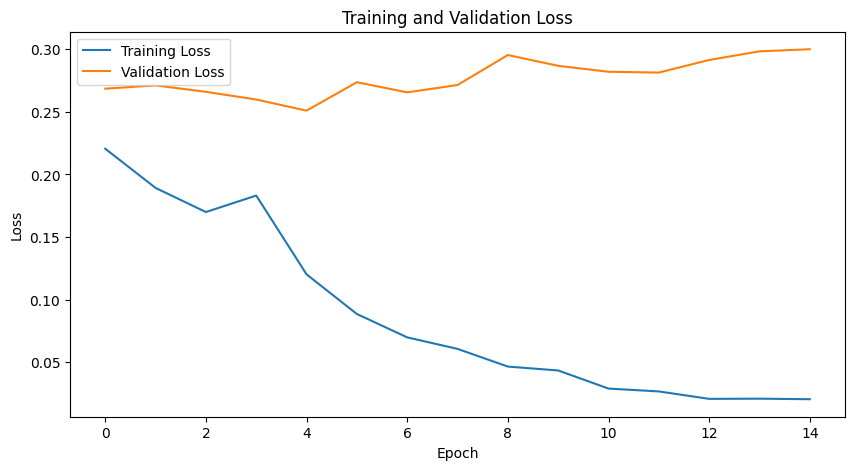

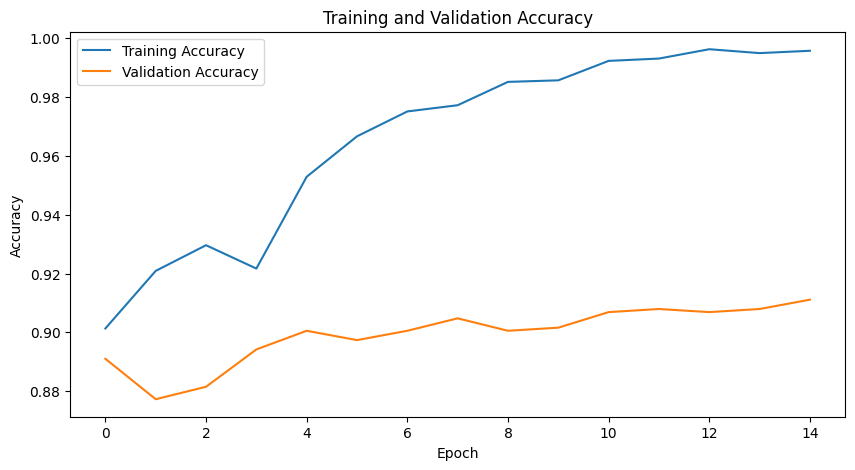

Epoch 1/100
----------


100%|██████████| 60/60 [00:22<00:00,  2.64it/s]

train Loss: 0.0921 Acc: 0.9677 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.41it/s]

val Loss: 0.2551 Acc: 0.8995 CD Loss: 0.0000
Epoch 2/100
----------



100%|██████████| 60/60 [00:19<00:00,  3.11it/s]

train Loss: 0.0813 Acc: 0.9693 CD Loss: 0.0000



100%|██████████| 15/15 [00:06<00:00,  2.37it/s]

val Loss: 0.2642 Acc: 0.9037 CD Loss: 0.0000
Epoch 3/100
----------



100%|██████████| 60/60 [00:19<00:00,  3.10it/s]

train Loss: 0.0597 Acc: 0.9799 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.56it/s]

val Loss: 0.2703 Acc: 0.9037 CD Loss: 0.0000
Epoch 4/100
----------



100%|██████████| 60/60 [00:20<00:00,  2.92it/s]

train Loss: 0.0442 Acc: 0.9852 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.30it/s]

val Loss: 0.2912 Acc: 0.8995 CD Loss: 0.0000
Epoch 5/100
----------



100%|██████████| 60/60 [00:20<00:00,  3.00it/s]

train Loss: 0.0356 Acc: 0.9889 CD Loss: 0.0000



100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


val Loss: 0.3199 Acc: 0.8942 CD Loss: 0.0000
Epoch 6/100
----------


100%|██████████| 60/60 [00:21<00:00,  2.85it/s]

train Loss: 0.0323 Acc: 0.9902 CD Loss: 0.0000



100%|██████████| 15/15 [00:05<00:00,  2.82it/s]

val Loss: 0.3570 Acc: 0.8899 CD Loss: 0.0000
Epoch 7/100
----------



100%|██████████| 60/60 [00:20<00:00,  2.88it/s]

train Loss: 0.0331 Acc: 0.9870 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.43it/s]

val Loss: 0.3260 Acc: 0.9026 CD Loss: 0.0000
Epoch 8/100
----------



 52%|█████▏    | 31/60 [00:11<00:09,  3.12it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2276197880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 70%|███████   | 42/60 [00:15<00:05,  3.08it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2276197880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/ut

train Loss: 0.0272 Acc: 0.9915 CD Loss: 0.0000



100%|██████████| 15/15 [00:05<00:00,  2.76it/s]

val Loss: 0.3015 Acc: 0.9079 CD Loss: 0.0000
Epoch 9/100
----------



100%|██████████| 60/60 [00:19<00:00,  3.16it/s]

train Loss: 0.0182 Acc: 0.9950 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.39it/s]

val Loss: 0.3262 Acc: 0.9069 CD Loss: 0.0000
Epoch 10/100
----------



100%|██████████| 60/60 [00:21<00:00,  2.84it/s]


train Loss: 0.0141 Acc: 0.9966 CD Loss: 0.0000


100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


val Loss: 0.3455 Acc: 0.9037 CD Loss: 0.0000
Epoch 11/100
----------


100%|██████████| 60/60 [00:21<00:00,  2.85it/s]

train Loss: 0.0152 Acc: 0.9966 CD Loss: 0.0000



100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


val Loss: 0.3389 Acc: 0.9090 CD Loss: 0.0000
Early stopping triggered after 11 epochs
Training complete in 4m 46s
Best val loss: 0.2551


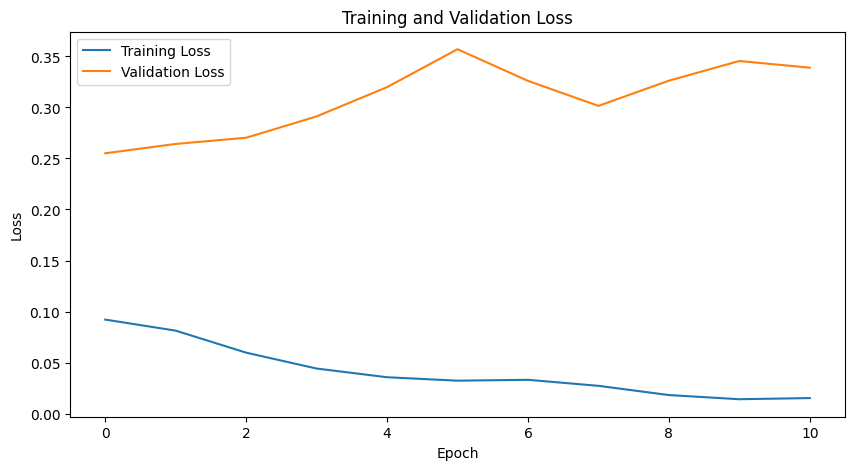

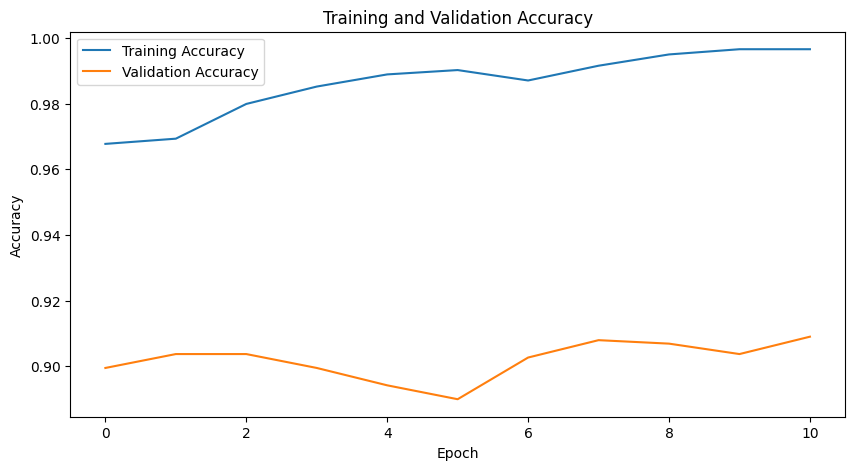

Epoch 1/100
----------


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]

train Loss: 0.0734 Acc: 0.9759 CD Loss: 0.0000



100%|██████████| 15/15 [00:05<00:00,  2.78it/s]

val Loss: 0.2887 Acc: 0.9037 CD Loss: 0.0000
Epoch 2/100
----------



100%|██████████| 60/60 [00:20<00:00,  2.97it/s]

train Loss: 0.0580 Acc: 0.9807 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.60it/s]

val Loss: 0.2859 Acc: 0.9069 CD Loss: 0.0000
Epoch 3/100
----------



100%|██████████| 60/60 [00:19<00:00,  3.13it/s]

train Loss: 0.0516 Acc: 0.9833 CD Loss: 0.0000



100%|██████████| 15/15 [00:06<00:00,  2.37it/s]

val Loss: 0.2958 Acc: 0.8974 CD Loss: 0.0000
Epoch 4/100
----------



100%|██████████| 60/60 [00:19<00:00,  3.16it/s]

train Loss: 0.0415 Acc: 0.9878 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.53it/s]

val Loss: 0.2832 Acc: 0.9058 CD Loss: 0.0000
Epoch 5/100
----------



100%|██████████| 60/60 [00:20<00:00,  2.87it/s]

train Loss: 0.0436 Acc: 0.9860 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


val Loss: 0.3012 Acc: 0.9069 CD Loss: 0.0000
Epoch 6/100
----------


100%|██████████| 60/60 [00:20<00:00,  2.89it/s]

train Loss: 0.0262 Acc: 0.9934 CD Loss: 0.0000



100%|██████████| 15/15 [00:06<00:00,  2.38it/s]

val Loss: 0.3129 Acc: 0.9048 CD Loss: 0.0000
Epoch 7/100
----------



100%|██████████| 60/60 [00:19<00:00,  3.16it/s]

train Loss: 0.0207 Acc: 0.9952 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.58it/s]

val Loss: 0.3612 Acc: 0.8942 CD Loss: 0.0000
Epoch 8/100
----------



100%|██████████| 60/60 [00:20<00:00,  2.91it/s]

train Loss: 0.0174 Acc: 0.9966 CD Loss: 0.0000



100%|██████████| 15/15 [00:05<00:00,  2.93it/s]

val Loss: 0.3360 Acc: 0.9079 CD Loss: 0.0000
Epoch 9/100
----------



100%|██████████| 60/60 [00:19<00:00,  3.11it/s]

train Loss: 0.0165 Acc: 0.9958 CD Loss: 0.0000



100%|██████████| 15/15 [00:05<00:00,  2.95it/s]

val Loss: 0.3690 Acc: 0.9037 CD Loss: 0.0000
Epoch 10/100
----------



100%|██████████| 60/60 [00:19<00:00,  3.00it/s]

train Loss: 0.0138 Acc: 0.9963 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


val Loss: 0.3388 Acc: 0.9048 CD Loss: 0.0000
Epoch 11/100
----------


100%|██████████| 60/60 [00:21<00:00,  2.81it/s]

train Loss: 0.0108 Acc: 0.9981 CD Loss: 0.0000



100%|██████████| 15/15 [00:05<00:00,  2.71it/s]

val Loss: 0.3338 Acc: 0.9026 CD Loss: 0.0000
Epoch 12/100
----------



100%|██████████| 60/60 [00:19<00:00,  3.12it/s]

train Loss: 0.0101 Acc: 0.9979 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.59it/s]

val Loss: 0.3367 Acc: 0.9026 CD Loss: 0.0000
Epoch 13/100
----------



100%|██████████| 60/60 [00:21<00:00,  2.83it/s]

train Loss: 0.0082 Acc: 0.9989 CD Loss: 0.0000



100%|██████████| 15/15 [00:04<00:00,  3.61it/s]

val Loss: 0.3433 Acc: 0.9048 CD Loss: 0.0000
Epoch 14/100
----------



100%|██████████| 60/60 [00:19<00:00,  3.05it/s]

train Loss: 0.0089 Acc: 0.9981 CD Loss: 0.0000



100%|██████████| 15/15 [00:05<00:00,  2.81it/s]


val Loss: 0.3456 Acc: 0.9058 CD Loss: 0.0000
Early stopping triggered after 14 epochs
Training complete in 5m 53s
Best val loss: 0.2832


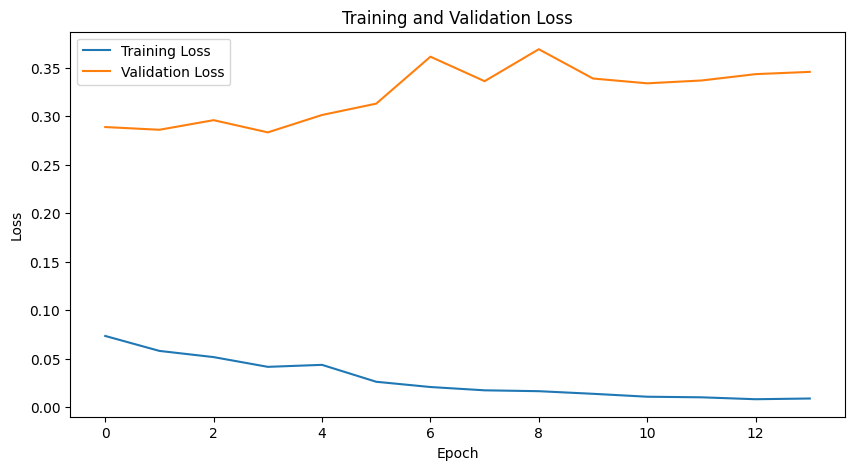

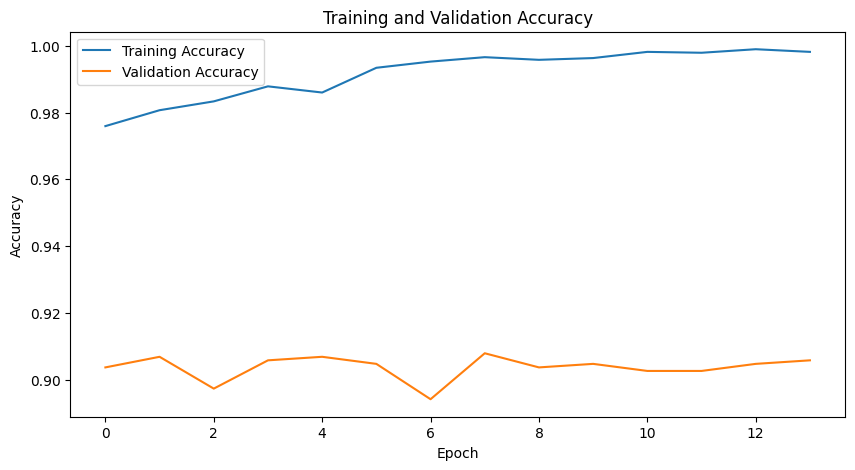

In [ ]:
wb_ratio = len(wb_no_patch)/len(complete_dataset)

not_two_ratio = 1 - wb_ratio
two_weight = 1/wb_ratio
not_two_weight = 1/ not_two_ratio
weights = np.asarray([not_two_weight, two_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())

mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64
        self.epochs = 100
        self.lr = 0.001
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0


regularizer_rate = args.regularizer_rate
num_epochs = args.epochs
seeds = [1, 11, 111]


torch.manual_seed(args.seed)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model.to(device)
#params_to_update = model.classifier.parameters()
params_to_update = model.parameters()





for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Initialize model, optimizer, and loss function
    params_to_update = model.parameters()
   #initialize_weights(model)
    optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)
    #criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_places_wb_balanced_dist_{seed}" + "train.pt"))

### Extract Activations Correlations

Computing activations and saving to activations.npy


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-10-d7242f12d550>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

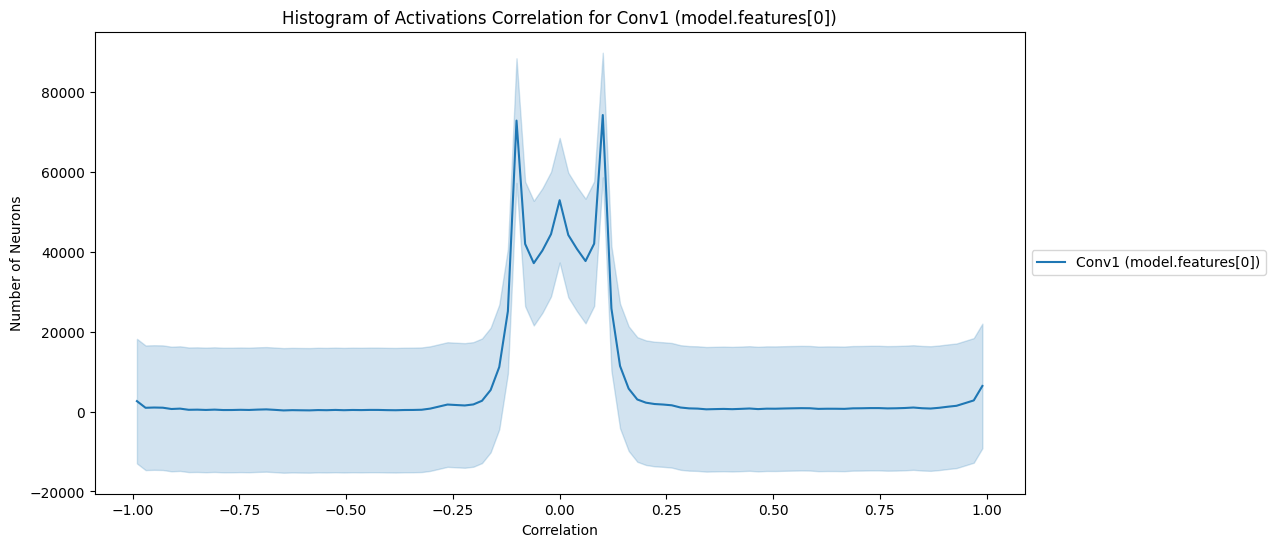

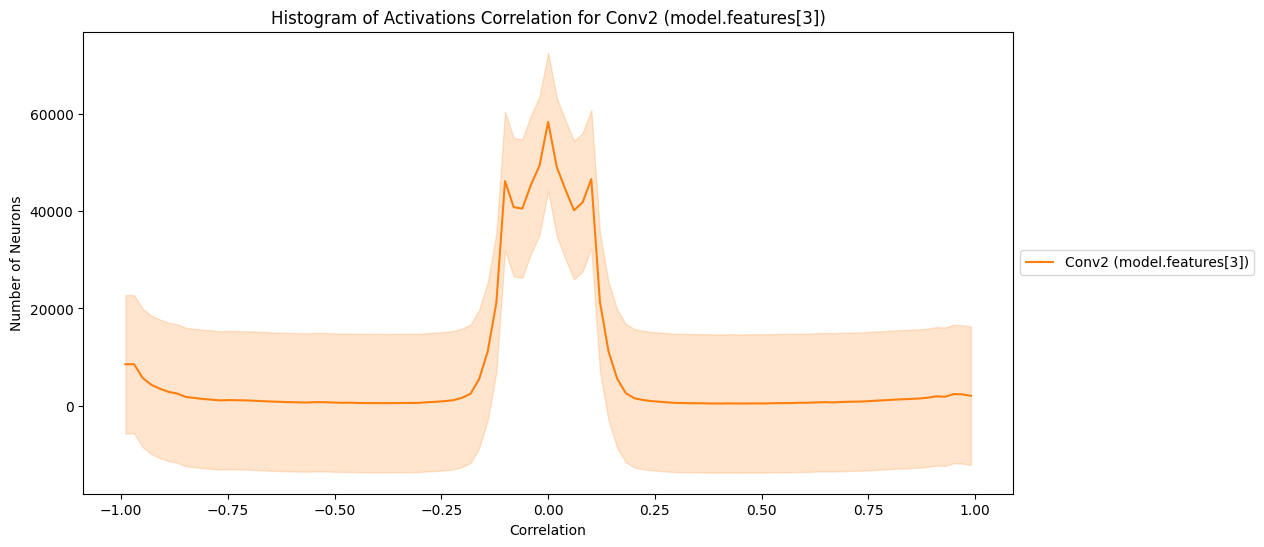

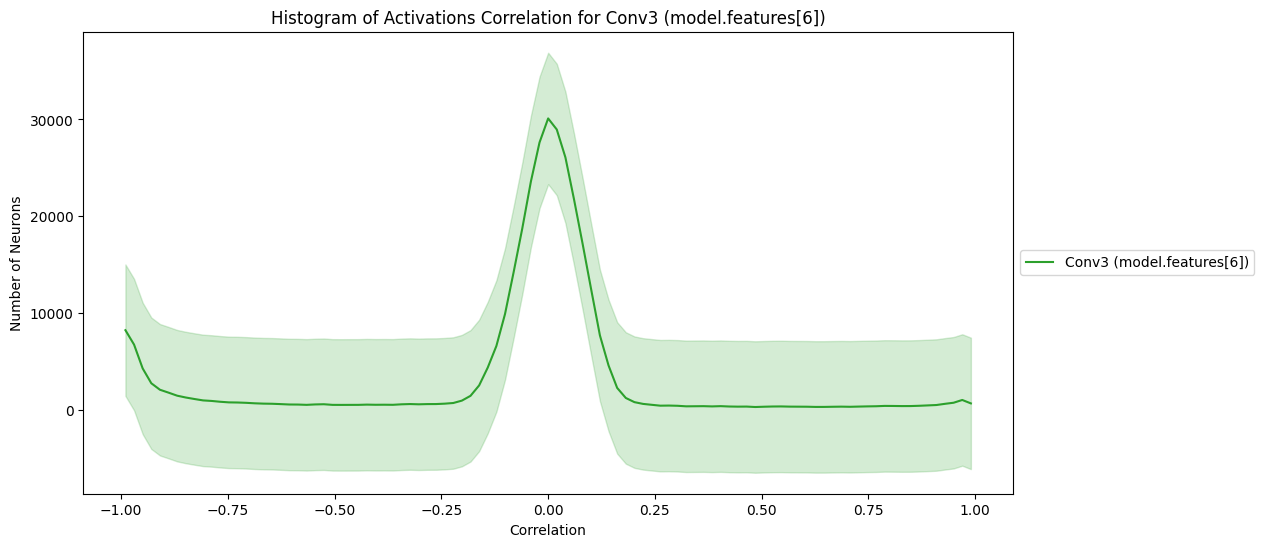

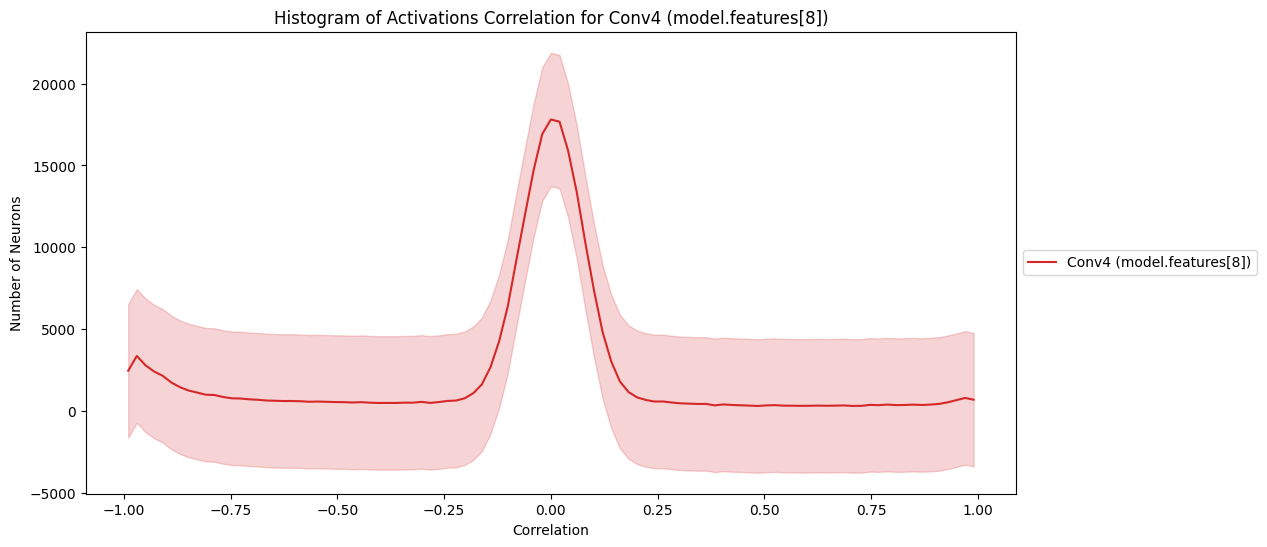

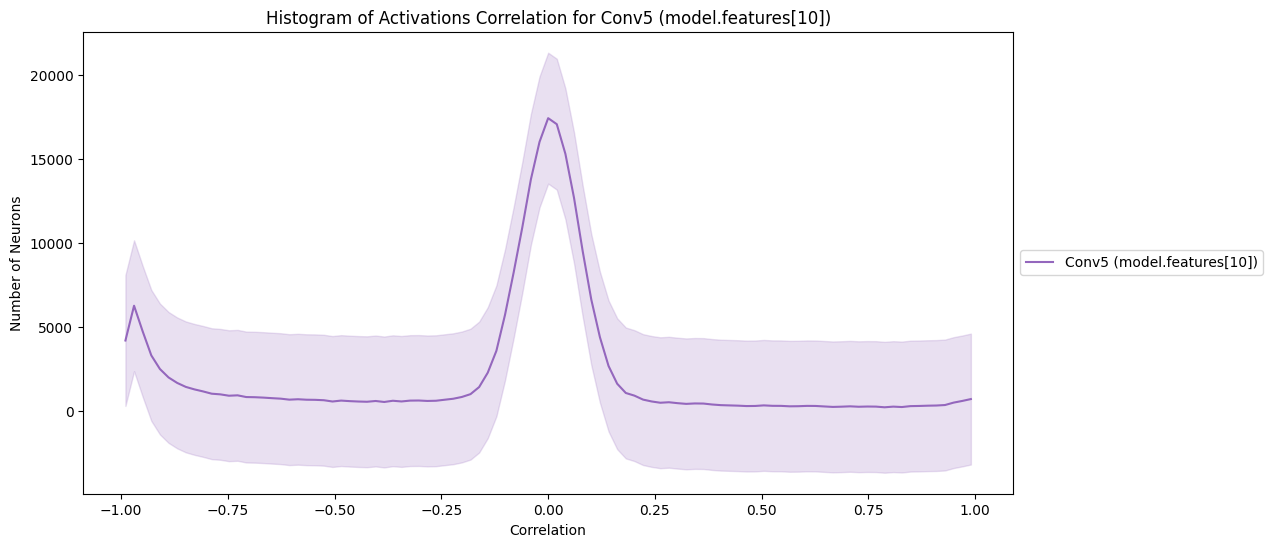

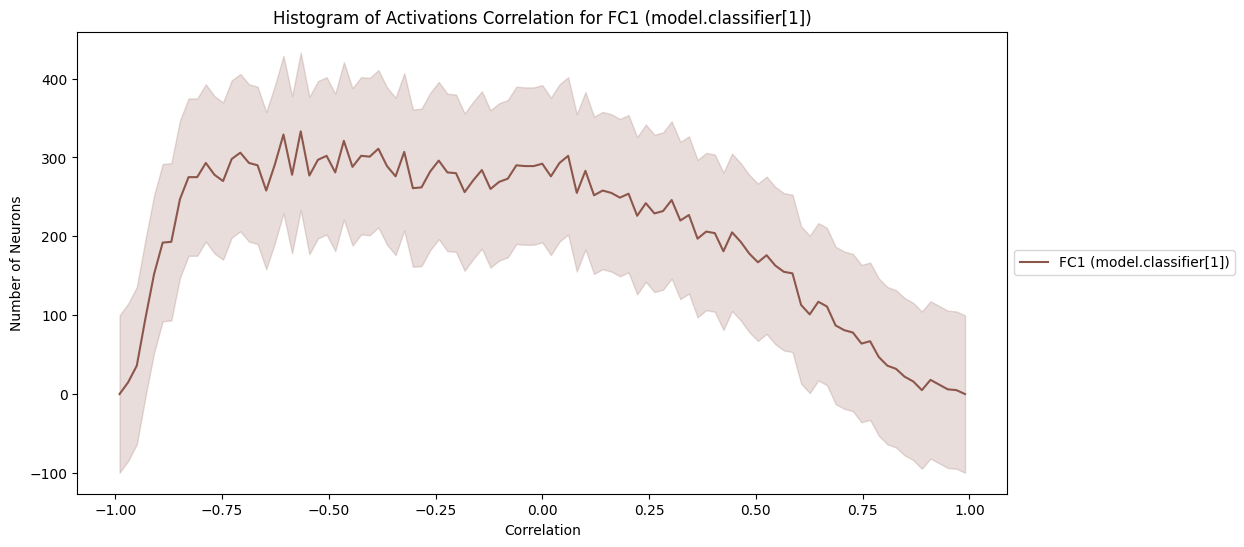

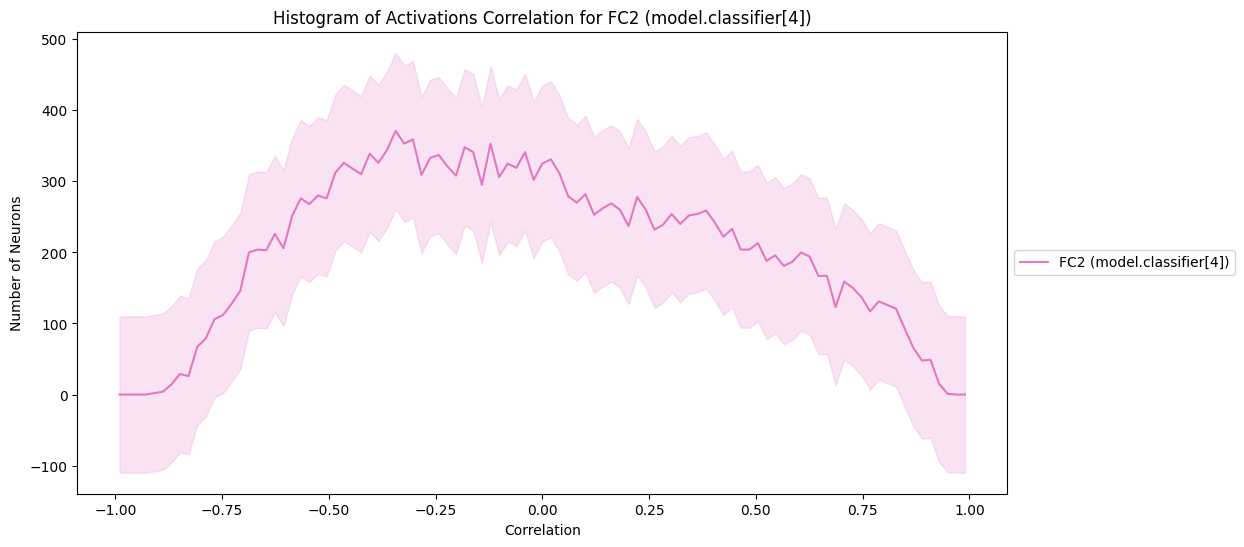

<ipython-input-10-d7242f12d550>:203: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


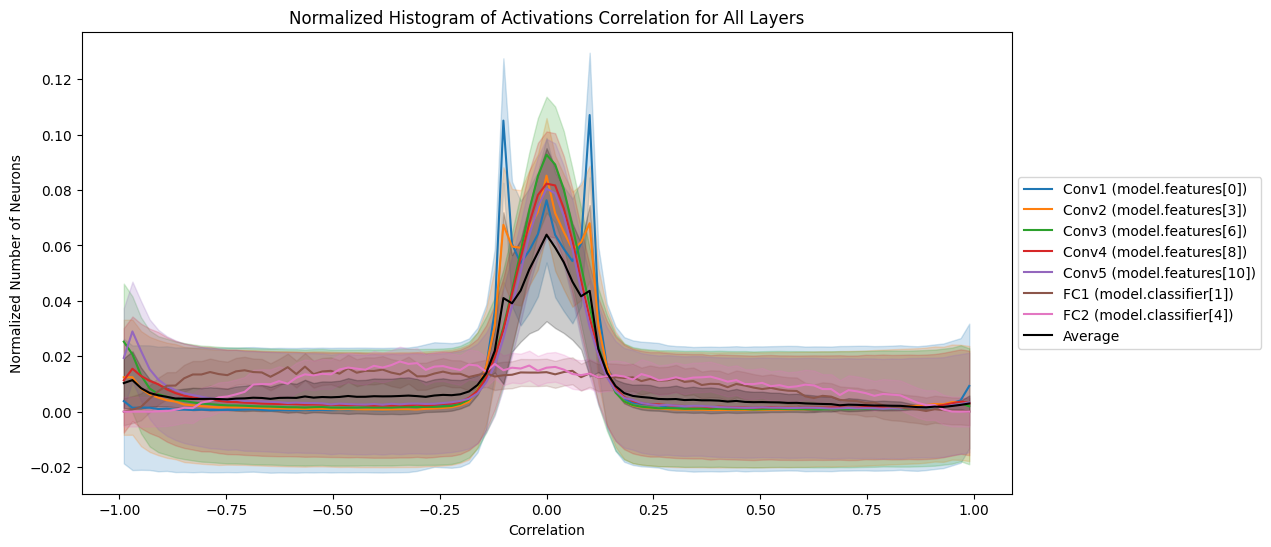

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

# Custom dataset class for loading images
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image

# Load and prepare the model
def load_model(model_path):
    model = models.alexnet(pretrained=False)
    model.classifier[-1] = torch.nn.Linear(4096, 2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            if layer < 13:  # Layer in model.features
                tensor = image_tensor
                for idx, layer_module in enumerate(model.features[:layer + 1]):
                    tensor = layer_module(tensor)
            else:  # Layer in model.classifier
                tensor = model.features(image_tensor)
                tensor = model.avgpool(tensor)
                tensor = torch.flatten(tensor, 1)
                for idx, layer_module in enumerate(model.classifier[:layer - 12]):
                    tensor = layer_module(tensor)

            activation = tensor.cpu().numpy()
            activations.append(activation)

    return activations

def process_images_in_folder(model, folder_path, layer, batch_size=5):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith(('.jpg', '.png'))]

    dataset = ImageDataset(image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    activations = preprocess_and_extract_activations(model, dataloader, layer)
    all_layer_activations.extend(activations)
    torch.cuda.empty_cache()
    gc.collect()

    return all_layer_activations


def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/{filename}'
    np.save(drive_path, all_layer_activations)

def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        return load_activations(activations_file)

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    save_activations(all_layer_activations, activations_file)
    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 3, 6, 8, 10, 14, 17]
layer_names = {
    0: "Conv1 (model.features[0])",
    3: "Conv2 (model.features[3])",
    6: "Conv3 (model.features[6])",
    8: "Conv4 (model.features[8])",
    10: "Conv5 (model.features[10])",
    14: "FC1 (model.classifier[1])",
    17: "FC2 (model.classifier[4])"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']

patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/test/wb_patch'
no_patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_balanced/test/wb_no_patch'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_balanced_dist_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_balanced_dist_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_balanced_dist_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, patch_waterbird_folder_path, no_patch_waterbird_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


### Two sample T-test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations and inspect the structure
def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_balanced/{filename}'
    activations = np.load(drive_path, allow_pickle=True)
    print(f"Type of loaded activations: {type(activations)}")

    if isinstance(activations, np.ndarray) and activations.shape == ():
        # Check if the single element is the dictionary we need
        activations = activations.item()
        print(f"After extracting item, type: {type(activations)}")

    return activations


# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(activations):
    t_test_results = {}
    for layer, data in activations.items():
        wp_activations = np.vstack(data['wp'])
        wo_activations = np.vstack(data['wo'])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        # Bonferroni Correction: Calculate the number of comparisons (neurons)
        num_comparisons = wp_activations.shape[1]  # Number of neurons
        adjusted_p_values = np.minimum(ttest_result.pvalue * num_comparisons, 1.0)  # Adjust p-values

        t_test_results[layer] = {
            'ttest': ttest_result,
            'raw_pvalue': ttest_result.pvalue,  # Store raw p-values
            'adjusted_pvalue': adjusted_p_values,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        raw_pvalue = results['raw_pvalue']
        adjusted_pvalue = results['adjusted_pvalue']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        below_or_equal_0_05_raw = np.mean(raw_pvalue <= 0.05) * 100
        below_or_equal_0_02_raw = np.mean(raw_pvalue <= 0.02) * 100
        below_or_equal_0_05_adj = np.mean(adjusted_pvalue <= 0.05) * 100
        below_or_equal_0_02_adj = np.mean(adjusted_pvalue <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test (before Bonferroni correction):")
        print(f"    Percentage of neurons with raw p-value <= 0.05: {below_or_equal_0_05_raw:.2f}%")
        print(f"    Percentage of neurons with raw p-value <= 0.02: {below_or_equal_0_02_raw:.2f}%")
        print("  T-Test (after Bonferroni correction):")
        print(f"    Percentage of neurons with adjusted p-value <= 0.05: {below_or_equal_0_05_adj:.2f}%")
        print(f"    Percentage of neurons with adjusted p-value <= 0.02: {below_or_equal_0_02_adj:.2f}%")
        print("-" * 50)



# Main execution
activations_file = 'activations.npy'
all_layer_activations = load_activations(activations_file)
t_test_results = perform_two_sample_t_tests(all_layer_activations)
print_t_test_results(t_test_results)

Type of loaded activations: <class 'numpy.ndarray'>
After extracting item, type: <class 'dict'>
Layer 0:
  WP Activations:
    Mean: -0.5571
  WO Activations:
    Mean: -0.5544
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 15.07%
    Percentage of neurons with raw p-value <= 0.02: 11.48%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 5.82%
    Percentage of neurons with adjusted p-value <= 0.02: 5.76%
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: -3.3347
  WO Activations:
    Mean: -2.6385
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 25.03%
    Percentage of neurons with raw p-value <= 0.02: 20.07%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 13.02%
    Percentage of neurons with adjusted p-value <= 0.02: 12.95%
---------------------------------------

## Waterbirds wb original distribution

### Train

In [ ]:
#Train
wb_no_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_wb/train/wb_no_patch'
lb_no_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_wb/train/lb_no_patch'
lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_wb/train/lb_patch'

#Test
test_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_wb/test/wb_patch'



# Create datasets for training and testing
wb_no_patch = WaterbirdDataset(path=wb_no_patch_path, is_waterbird=1, group_labels=[0] * len(os.listdir(wb_no_patch_path)))
lb_no_patch = WaterbirdDataset(path=lb_no_patch_path, is_waterbird=0, group_labels=[2] * len(os.listdir(lb_no_patch_path)))
#dataset_two_lp = MnistDataset(path=two_lp_path, is_waterbird=1, group_labels=[1] * len(os.listdir(two_lp_path)))
lb_patch = WaterbirdDataset(path=lb_patch_path, is_waterbird=0, group_labels=[3] * len(os.listdir(lb_patch_path)))

test_wb_patch = WaterbirdDataset(path=test_wb_patch_path, is_waterbird=1, group_labels=[1] * len(os.listdir(test_wb_patch_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((wb_no_patch, lb_no_patch, lb_patch))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = test_wb_patch

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 3724
num_val: 931
num_test: 300


Epoch 1/100
----------


100%|██████████| 59/59 [06:30<00:00,  6.61s/it]

train Loss: 0.1848 Acc: 0.9160 CD Loss: 0.0000



100%|██████████| 15/15 [01:33<00:00,  6.27s/it]

val Loss: 0.0470 Acc: 0.9817 CD Loss: 0.0000
Epoch 2/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.38it/s]

train Loss: 0.0740 Acc: 0.9667 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.33it/s]

val Loss: 0.0394 Acc: 0.9839 CD Loss: 0.0000
Epoch 3/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.38it/s]

train Loss: 0.0614 Acc: 0.9707 CD Loss: 0.0000



100%|██████████| 15/15 [00:03<00:00,  4.97it/s]

val Loss: 0.0350 Acc: 0.9839 CD Loss: 0.0000
Epoch 4/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.37it/s]

train Loss: 0.0517 Acc: 0.9726 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.06it/s]

val Loss: 0.0404 Acc: 0.9903 CD Loss: 0.0000
Epoch 5/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.53it/s]

train Loss: 0.0456 Acc: 0.9788 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.17it/s]


val Loss: 0.0319 Acc: 0.9860 CD Loss: 0.0000
Epoch 6/100
----------


100%|██████████| 59/59 [00:11<00:00,  5.21it/s]

train Loss: 0.0371 Acc: 0.9804 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.30it/s]

val Loss: 0.0306 Acc: 0.9882 CD Loss: 0.0000
Epoch 7/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.46it/s]

train Loss: 0.0333 Acc: 0.9836 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.34it/s]

val Loss: 0.0303 Acc: 0.9903 CD Loss: 0.0000
Epoch 8/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.52it/s]

train Loss: 0.0220 Acc: 0.9906 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.29it/s]

val Loss: 0.0333 Acc: 0.9903 CD Loss: 0.0000
Epoch 9/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.64it/s]

train Loss: 0.0163 Acc: 0.9933 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.42it/s]

val Loss: 0.0279 Acc: 0.9903 CD Loss: 0.0000
Epoch 10/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.53it/s]

train Loss: 0.0159 Acc: 0.9944 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.42it/s]


val Loss: 0.0346 Acc: 0.9893 CD Loss: 0.0000
Epoch 11/100
----------


100%|██████████| 59/59 [00:11<00:00,  5.27it/s]

train Loss: 0.0116 Acc: 0.9960 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.23it/s]

val Loss: 0.0297 Acc: 0.9903 CD Loss: 0.0000
Epoch 12/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.52it/s]

train Loss: 0.0100 Acc: 0.9957 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.34it/s]

val Loss: 0.0325 Acc: 0.9903 CD Loss: 0.0000
Epoch 13/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.60it/s]

train Loss: 0.0096 Acc: 0.9968 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.20it/s]

val Loss: 0.0296 Acc: 0.9903 CD Loss: 0.0000
Epoch 14/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.60it/s]

train Loss: 0.0086 Acc: 0.9973 CD Loss: 0.0000



100%|██████████| 15/15 [00:03<00:00,  5.00it/s]

val Loss: 0.0294 Acc: 0.9903 CD Loss: 0.0000
Epoch 15/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.65it/s]

train Loss: 0.0089 Acc: 0.9968 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.19it/s]


val Loss: 0.0326 Acc: 0.9903 CD Loss: 0.0000
Epoch 16/100
----------


100%|██████████| 59/59 [00:11<00:00,  5.29it/s]

train Loss: 0.0097 Acc: 0.9979 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.44it/s]

val Loss: 0.0298 Acc: 0.9893 CD Loss: 0.0000
Epoch 17/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.59it/s]

train Loss: 0.0085 Acc: 0.9970 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.33it/s]

val Loss: 0.0292 Acc: 0.9893 CD Loss: 0.0000
Epoch 18/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.51it/s]

train Loss: 0.0086 Acc: 0.9962 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.39it/s]

val Loss: 0.0307 Acc: 0.9903 CD Loss: 0.0000
Epoch 19/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.46it/s]

train Loss: 0.0090 Acc: 0.9976 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.36it/s]


val Loss: 0.0307 Acc: 0.9893 CD Loss: 0.0000
Early stopping triggered after 19 epochs
Training complete in 12m 19s
Best val loss: 0.0279


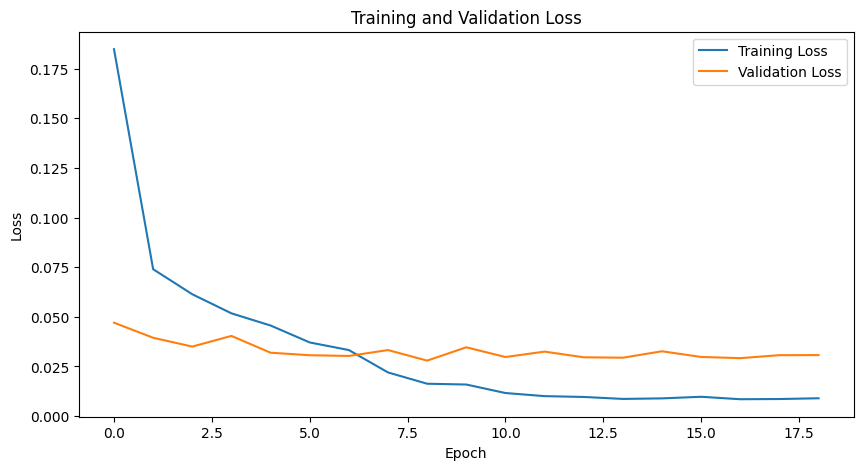

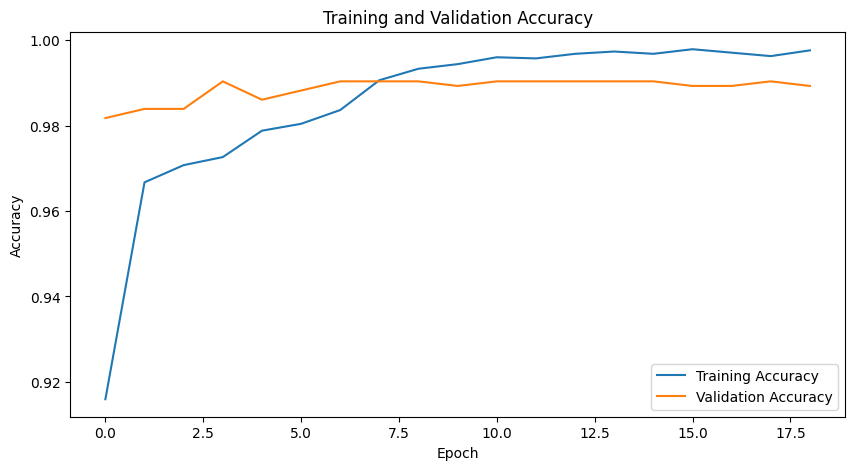

Epoch 1/100
----------


100%|██████████| 59/59 [00:11<00:00,  5.25it/s]

train Loss: 0.0148 Acc: 0.9938 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.32it/s]

val Loss: 0.0277 Acc: 0.9903 CD Loss: 0.0000
Epoch 2/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.50it/s]

train Loss: 0.0249 Acc: 0.9890 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.32it/s]

val Loss: 0.0304 Acc: 0.9893 CD Loss: 0.0000
Epoch 3/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.67it/s]

train Loss: 0.0107 Acc: 0.9957 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.34it/s]

val Loss: 0.0328 Acc: 0.9893 CD Loss: 0.0000
Epoch 4/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.63it/s]

train Loss: 0.0088 Acc: 0.9970 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.03it/s]

val Loss: 0.0377 Acc: 0.9871 CD Loss: 0.0000
Epoch 5/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.56it/s]

train Loss: 0.0079 Acc: 0.9973 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.03it/s]


val Loss: 0.0384 Acc: 0.9903 CD Loss: 0.0000
Epoch 6/100
----------


100%|██████████| 59/59 [00:11<00:00,  5.15it/s]

train Loss: 0.0053 Acc: 0.9984 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.30it/s]

val Loss: 0.0393 Acc: 0.9893 CD Loss: 0.0000
Epoch 7/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.52it/s]

train Loss: 0.0048 Acc: 0.9989 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.38it/s]

val Loss: 0.0350 Acc: 0.9893 CD Loss: 0.0000
Epoch 8/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.57it/s]

train Loss: 0.0043 Acc: 0.9984 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.51it/s]

val Loss: 0.0407 Acc: 0.9882 CD Loss: 0.0000
Epoch 9/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.58it/s]

train Loss: 0.0022 Acc: 0.9997 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.30it/s]

val Loss: 0.0348 Acc: 0.9893 CD Loss: 0.0000
Epoch 10/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.66it/s]

train Loss: 0.0044 Acc: 0.9979 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.41it/s]


val Loss: 0.0317 Acc: 0.9914 CD Loss: 0.0000
Epoch 11/100
----------


100%|██████████| 59/59 [00:11<00:00,  5.28it/s]

train Loss: 0.0028 Acc: 0.9987 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.29it/s]


val Loss: 0.0346 Acc: 0.9882 CD Loss: 0.0000
Early stopping triggered after 11 epochs
Training complete in 2m 35s
Best val loss: 0.0277


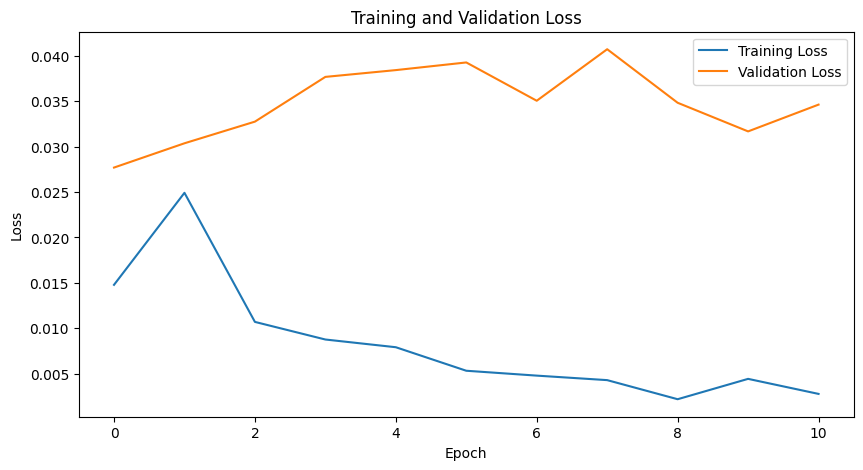

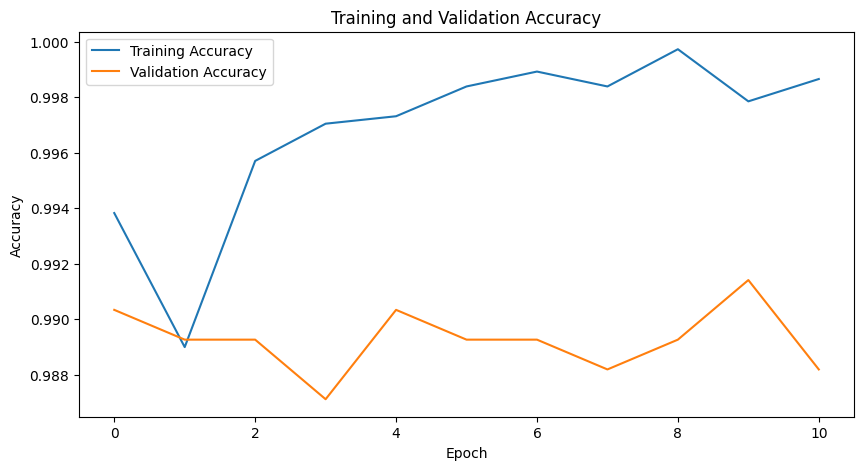

Epoch 1/100
----------


100%|██████████| 59/59 [00:11<00:00,  5.32it/s]

train Loss: 0.0112 Acc: 0.9957 CD Loss: 0.0000



100%|██████████| 15/15 [00:03<00:00,  5.00it/s]

val Loss: 0.0337 Acc: 0.9914 CD Loss: 0.0000
Epoch 2/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.60it/s]

train Loss: 0.0079 Acc: 0.9970 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.02it/s]

val Loss: 0.0366 Acc: 0.9914 CD Loss: 0.0000
Epoch 3/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.59it/s]

train Loss: 0.0111 Acc: 0.9944 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.30it/s]

val Loss: 0.0398 Acc: 0.9903 CD Loss: 0.0000
Epoch 4/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.60it/s]

train Loss: 0.0099 Acc: 0.9965 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.38it/s]

val Loss: 0.0481 Acc: 0.9893 CD Loss: 0.0000
Epoch 5/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.61it/s]

train Loss: 0.0056 Acc: 0.9981 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.32it/s]


val Loss: 0.0326 Acc: 0.9893 CD Loss: 0.0000
Epoch 6/100
----------


100%|██████████| 59/59 [00:11<00:00,  5.30it/s]

train Loss: 0.0037 Acc: 0.9987 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.24it/s]

val Loss: 0.0344 Acc: 0.9903 CD Loss: 0.0000
Epoch 7/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.60it/s]

train Loss: 0.0035 Acc: 0.9989 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.24it/s]

val Loss: 0.0383 Acc: 0.9914 CD Loss: 0.0000
Epoch 8/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.62it/s]

train Loss: 0.0025 Acc: 0.9997 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.29it/s]

val Loss: 0.0417 Acc: 0.9925 CD Loss: 0.0000
Epoch 9/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.68it/s]

train Loss: 0.0022 Acc: 0.9992 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.55it/s]

val Loss: 0.0485 Acc: 0.9903 CD Loss: 0.0000
Epoch 10/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.64it/s]

train Loss: 0.0025 Acc: 0.9992 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.49it/s]


val Loss: 0.0359 Acc: 0.9936 CD Loss: 0.0000
Epoch 11/100
----------


100%|██████████| 59/59 [00:11<00:00,  5.30it/s]

train Loss: 0.0023 Acc: 0.9989 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.01it/s]

val Loss: 0.0399 Acc: 0.9925 CD Loss: 0.0000
Epoch 12/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.70it/s]

train Loss: 0.0021 Acc: 0.9992 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.18it/s]

val Loss: 0.0394 Acc: 0.9925 CD Loss: 0.0000
Epoch 13/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.66it/s]

train Loss: 0.0015 Acc: 0.9997 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.26it/s]

val Loss: 0.0395 Acc: 0.9925 CD Loss: 0.0000
Epoch 14/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.51it/s]

train Loss: 0.0015 Acc: 0.9997 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.35it/s]

val Loss: 0.0372 Acc: 0.9914 CD Loss: 0.0000
Epoch 15/100
----------



100%|██████████| 59/59 [00:10<00:00,  5.67it/s]

train Loss: 0.0014 Acc: 0.9995 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.38it/s]


val Loss: 0.0364 Acc: 0.9914 CD Loss: 0.0000
Early stopping triggered after 15 epochs
Training complete in 3m 30s
Best val loss: 0.0326


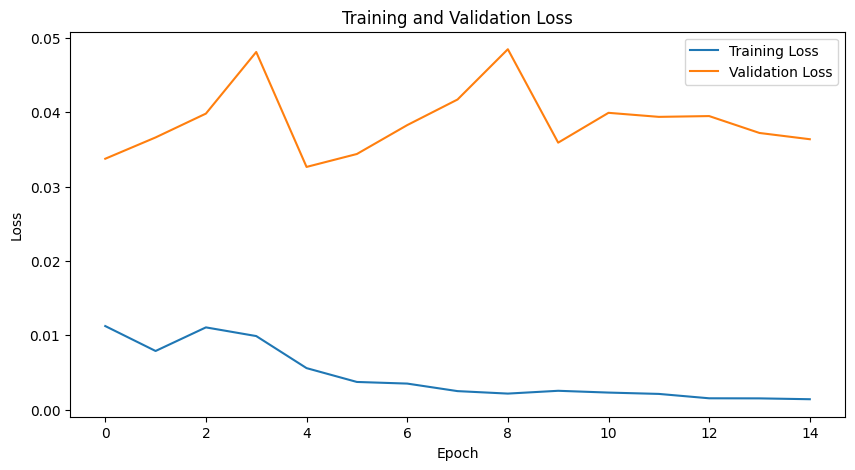

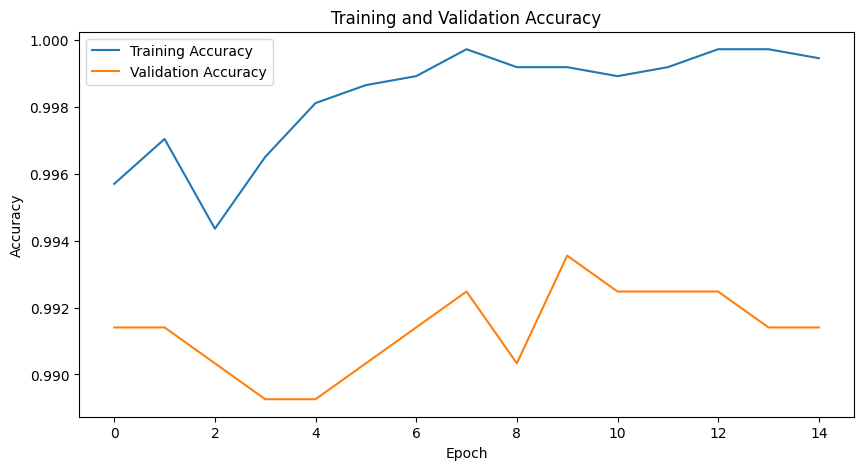

In [ ]:
wb_ratio = len(wb_no_patch)/len(complete_dataset)

not_two_ratio = 1 - wb_ratio
two_weight = 1/wb_ratio
not_two_weight = 1/ not_two_ratio
weights = np.asarray([not_two_weight, two_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())

mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64
        self.epochs = 100
        self.lr = 0.001
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0


regularizer_rate = args.regularizer_rate
num_epochs = args.epochs
seeds = [1, 11, 111]


torch.manual_seed(args.seed)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model.to(device)
#params_to_update = model.classifier.parameters()
params_to_update = model.parameters()





for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Initialize model, optimizer, and loss function
    params_to_update = model.parameters()
   #initialize_weights(model)
    optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)
    #criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_places_wb_dist_{seed}" + "train.pt"))

### Extract Activations & Correlations

Computing activations and saving to activations.npy


<ipython-input-17-f6de1b09b84c>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
<ipython-input-17-f6de1b09b84c>:165: Constant

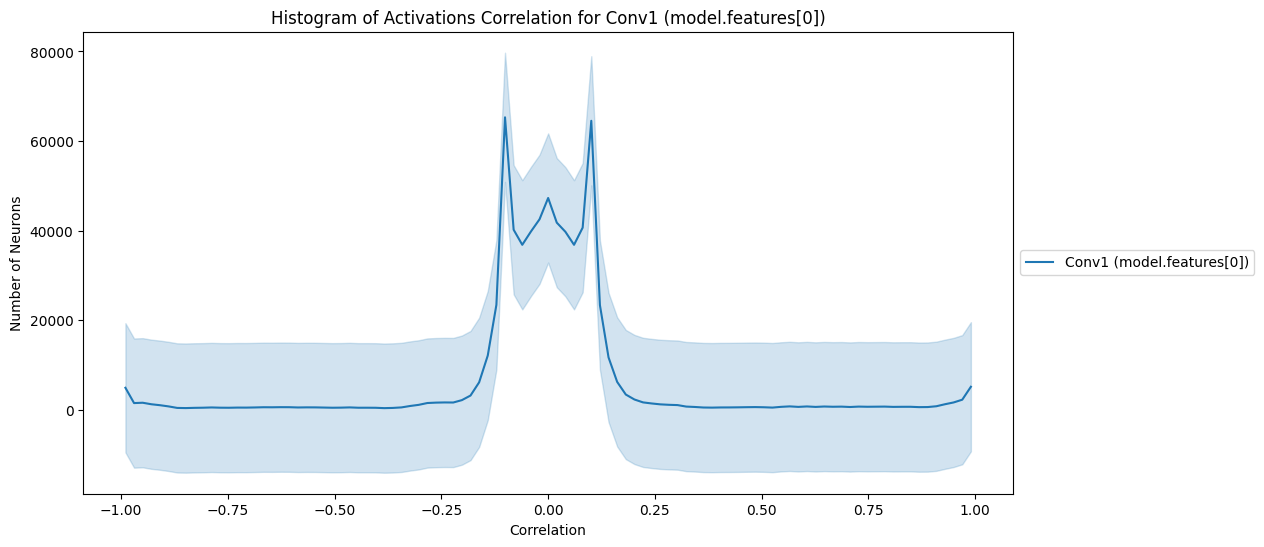

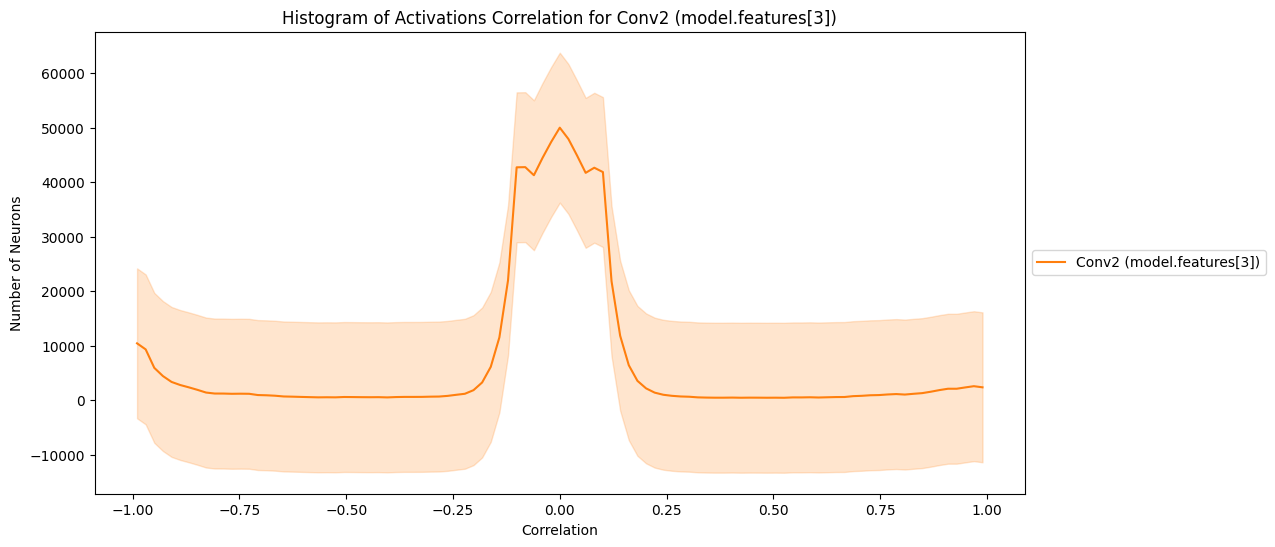

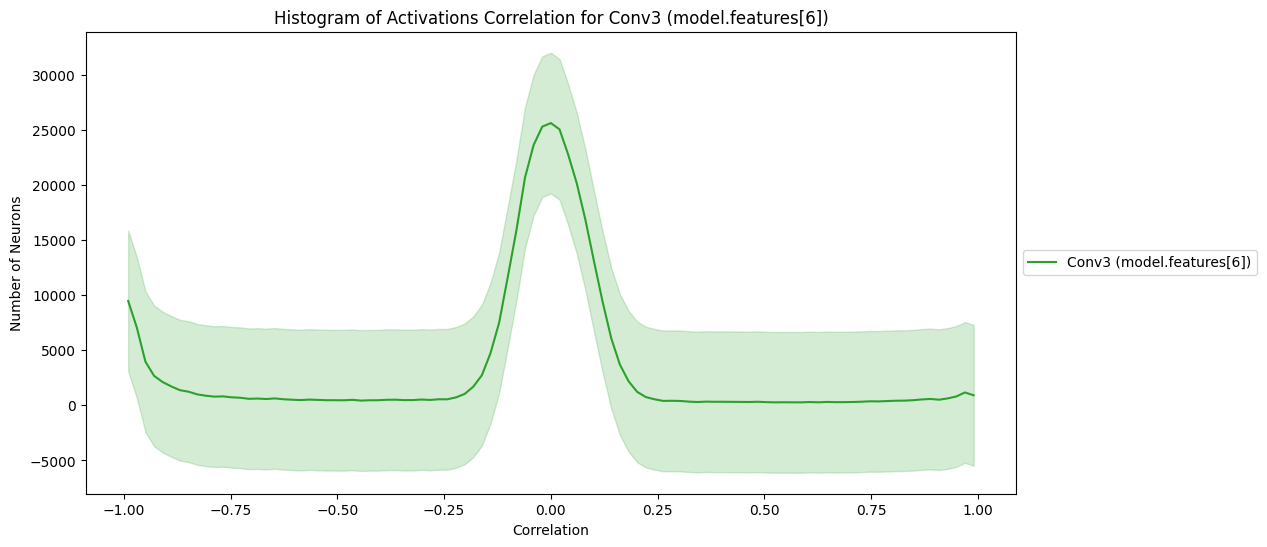

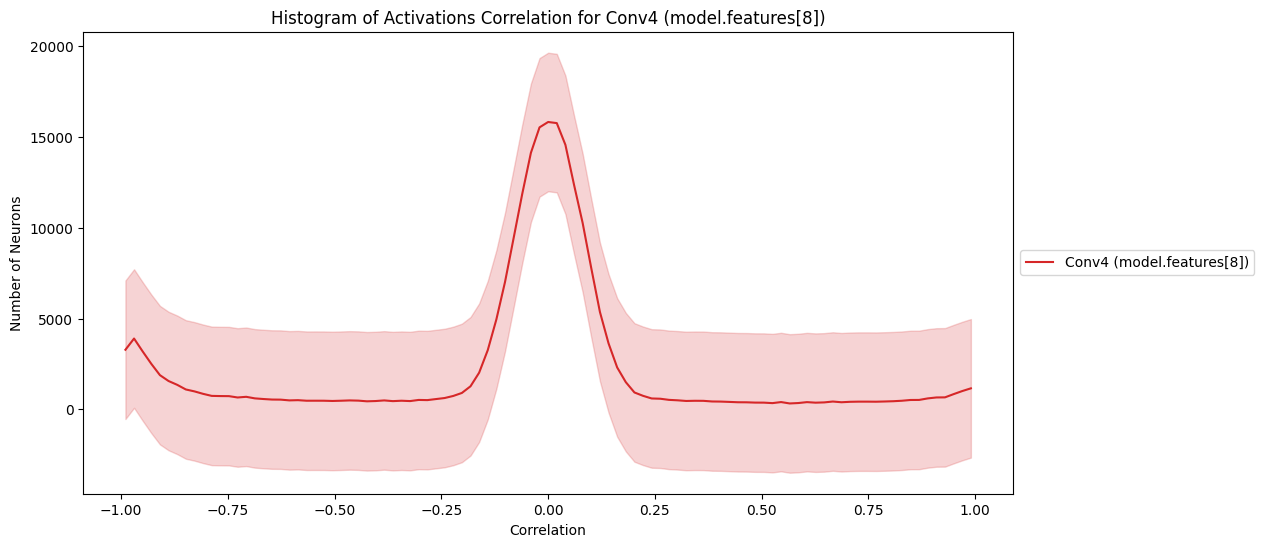

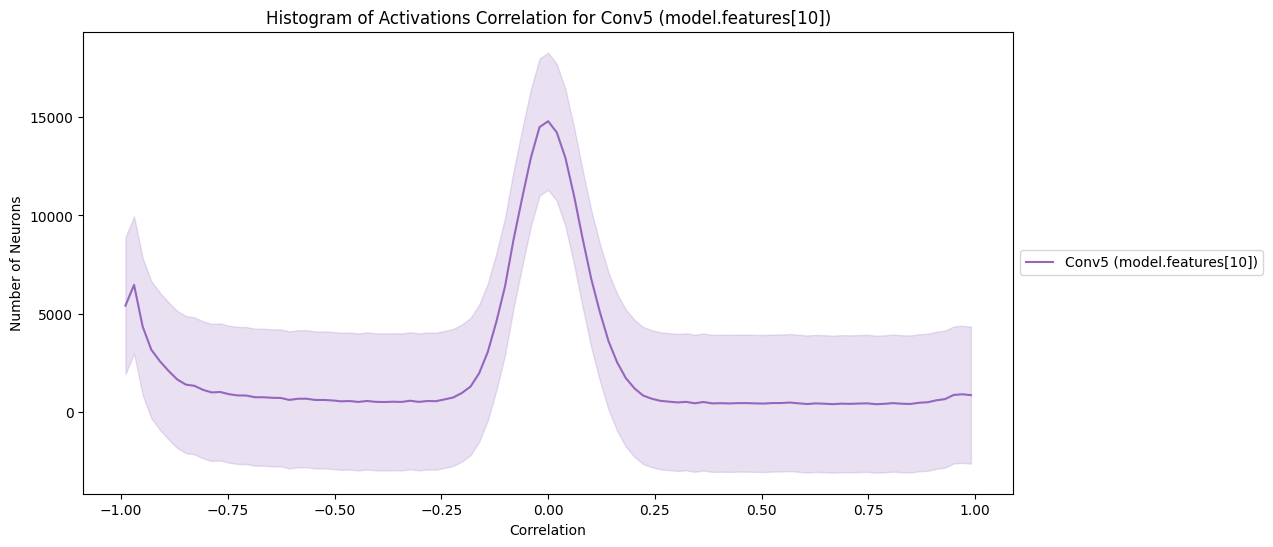

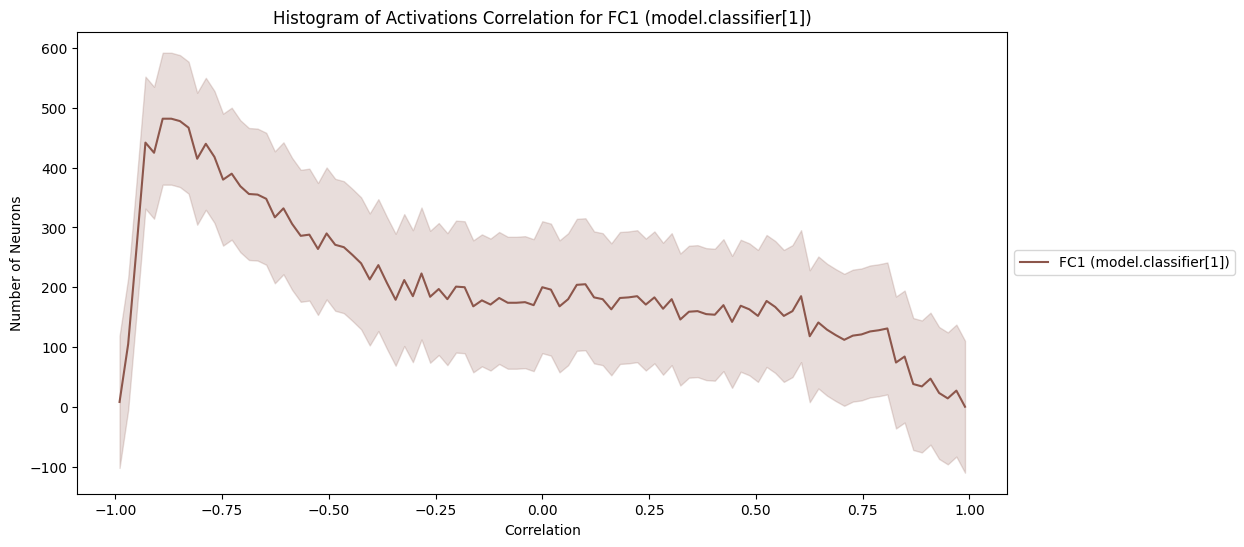

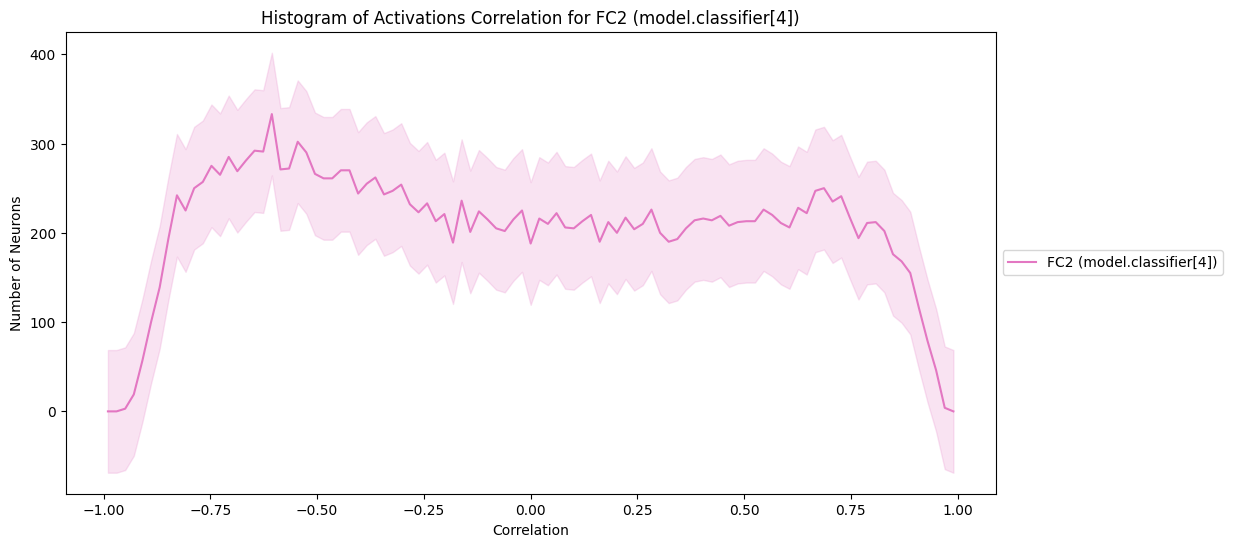

<ipython-input-17-f6de1b09b84c>:203: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


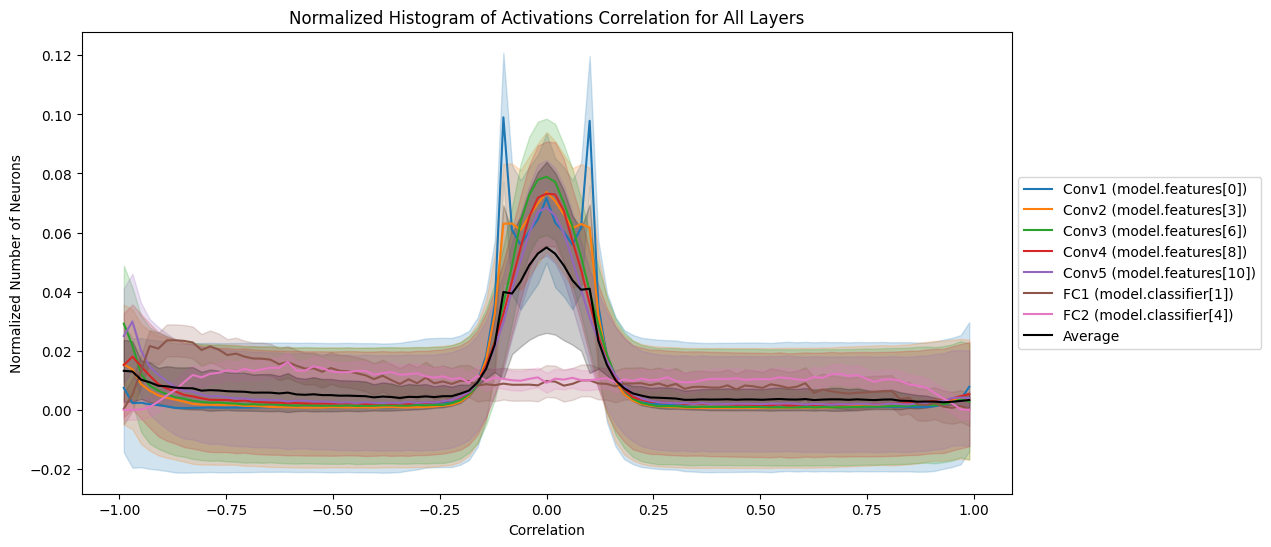

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

# Custom dataset class for loading images
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image

# Load and prepare the model
def load_model(model_path):
    model = models.alexnet(pretrained=False)
    model.classifier[-1] = torch.nn.Linear(4096, 2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            if layer < 13:  # Layer in model.features
                tensor = image_tensor
                for idx, layer_module in enumerate(model.features[:layer + 1]):
                    tensor = layer_module(tensor)
            else:  # Layer in model.classifier
                tensor = model.features(image_tensor)
                tensor = model.avgpool(tensor)
                tensor = torch.flatten(tensor, 1)
                for idx, layer_module in enumerate(model.classifier[:layer - 12]):
                    tensor = layer_module(tensor)

            activation = tensor.cpu().numpy()
            activations.append(activation)

    return activations

def process_images_in_folder(model, folder_path, layer, batch_size=5):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith(('.jpg', '.png'))]

    dataset = ImageDataset(image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    activations = preprocess_and_extract_activations(model, dataloader, layer)
    all_layer_activations.extend(activations)
    torch.cuda.empty_cache()
    gc.collect()

    return all_layer_activations


def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_wb/{filename}'
    np.save(drive_path, all_layer_activations)

def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_wb/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_wb/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        return load_activations(activations_file)

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    save_activations(all_layer_activations, activations_file)
    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 3, 6, 8, 10, 14, 17]
layer_names = {
    0: "Conv1 (model.features[0])",
    3: "Conv2 (model.features[3])",
    6: "Conv3 (model.features[6])",
    8: "Conv4 (model.features[8])",
    10: "Conv5 (model.features[10])",
    14: "FC1 (model.classifier[1])",
    17: "FC2 (model.classifier[4])"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']

patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_wb/test/wb_patch'
no_patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_wb/test/wb_no_patch'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_dist_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_dist_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_dist_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, patch_waterbird_folder_path, no_patch_waterbird_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


### Two-sample T-test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations and inspect the structure
def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_wb/{filename}'
    activations = np.load(drive_path, allow_pickle=True)
    print(f"Type of loaded activations: {type(activations)}")

    if isinstance(activations, np.ndarray) and activations.shape == ():
        # Check if the single element is the dictionary we need
        activations = activations.item()
        print(f"After extracting item, type: {type(activations)}")

    return activations

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(activations):
    t_test_results = {}
    for layer, data in activations.items():
        wp_activations = np.vstack(data['wp'])
        wo_activations = np.vstack(data['wo'])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        # Bonferroni Correction: Calculate the number of comparisons (neurons)
        num_comparisons = wp_activations.shape[1]  # Number of neurons
        adjusted_p_values = np.minimum(ttest_result.pvalue * num_comparisons, 1.0)  # Adjust p-values

        t_test_results[layer] = {
            'ttest': ttest_result,
            'raw_pvalue': ttest_result.pvalue,  # Store raw p-values
            'adjusted_pvalue': adjusted_p_values,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        raw_pvalue = results['raw_pvalue']
        adjusted_pvalue = results['adjusted_pvalue']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        below_or_equal_0_05_raw = np.mean(raw_pvalue <= 0.05) * 100
        below_or_equal_0_02_raw = np.mean(raw_pvalue <= 0.02) * 100
        below_or_equal_0_05_adj = np.mean(adjusted_pvalue <= 0.05) * 100
        below_or_equal_0_02_adj = np.mean(adjusted_pvalue <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test (before Bonferroni correction):")
        print(f"    Percentage of neurons with raw p-value <= 0.05: {below_or_equal_0_05_raw:.2f}%")
        print(f"    Percentage of neurons with raw p-value <= 0.02: {below_or_equal_0_02_raw:.2f}%")
        print("  T-Test (after Bonferroni correction):")
        print(f"    Percentage of neurons with adjusted p-value <= 0.05: {below_or_equal_0_05_adj:.2f}%")
        print(f"    Percentage of neurons with adjusted p-value <= 0.02: {below_or_equal_0_02_adj:.2f}%")
        print("-" * 50)



# Main execution
activations_file = 'activations.npy'
all_layer_activations = load_activations(activations_file)
t_test_results = perform_two_sample_t_tests(all_layer_activations)
print_t_test_results(t_test_results)

Type of loaded activations: <class 'numpy.ndarray'>
After extracting item, type: <class 'dict'>
Layer 0:
  WP Activations:
    Mean: -0.3369
  WO Activations:
    Mean: -0.3263
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 15.94%
    Percentage of neurons with raw p-value <= 0.02: 12.21%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 5.86%
    Percentage of neurons with adjusted p-value <= 0.02: 5.78%
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: -3.5075
  WO Activations:
    Mean: -2.7739
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 26.30%
    Percentage of neurons with raw p-value <= 0.02: 21.26%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 13.26%
    Percentage of neurons with adjusted p-value <= 0.02: 13.19%
---------------------------------------

## Waterbirds isic distribution

### Train

In [ ]:
#Train
wb_no_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_isic/train/wb_no_patch'
lb_no_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_isic/train/lb_no_patch'
lb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_isic/train/lb_patch'

#Test
test_wb_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_isic/test/wb_patch'



# Create datasets for training and testing
wb_no_patch = WaterbirdDataset(path=wb_no_patch_path, is_waterbird=1, group_labels=[0] * len(os.listdir(wb_no_patch_path)))
lb_no_patch = WaterbirdDataset(path=lb_no_patch_path, is_waterbird=0, group_labels=[2] * len(os.listdir(lb_no_patch_path)))
#dataset_two_lp = MnistDataset(path=two_lp_path, is_waterbird=1, group_labels=[1] * len(os.listdir(two_lp_path)))
lb_patch = WaterbirdDataset(path=lb_patch_path, is_waterbird=0, group_labels=[3] * len(os.listdir(lb_patch_path)))

test_wb_patch = WaterbirdDataset(path=test_wb_patch_path, is_waterbird=1, group_labels=[1] * len(os.listdir(test_wb_patch_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((wb_no_patch, lb_no_patch, lb_patch))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = test_wb_patch

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 3788
num_val: 947
num_test: 300


Epoch 1/100
----------


100%|██████████| 60/60 [06:17<00:00,  6.29s/it]


train Loss: 0.3995 Acc: 0.8289 CD Loss: 0.0000


100%|██████████| 15/15 [01:38<00:00,  6.55s/it]

val Loss: 0.3180 Acc: 0.8606 CD Loss: 0.0000
Epoch 2/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.57it/s]


train Loss: 0.2734 Acc: 0.8762 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.14it/s]

val Loss: 0.2931 Acc: 0.8733 CD Loss: 0.0000
Epoch 3/100
----------



100%|██████████| 60/60 [00:11<00:00,  5.43it/s]


train Loss: 0.2188 Acc: 0.9034 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]

val Loss: 0.2788 Acc: 0.8796 CD Loss: 0.0000
Epoch 4/100
----------



100%|██████████| 60/60 [00:11<00:00,  5.41it/s]


train Loss: 0.1824 Acc: 0.9253 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]

val Loss: 0.2745 Acc: 0.8870 CD Loss: 0.0000
Epoch 5/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.55it/s]


train Loss: 0.1527 Acc: 0.9348 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]


val Loss: 0.2734 Acc: 0.8955 CD Loss: 0.0000
Epoch 6/100
----------


100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


train Loss: 0.1284 Acc: 0.9496 CD Loss: 0.0000


100%|██████████| 15/15 [00:03<00:00,  4.94it/s]

val Loss: 0.2880 Acc: 0.8881 CD Loss: 0.0000
Epoch 7/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.49it/s]


train Loss: 0.1062 Acc: 0.9588 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.02it/s]

val Loss: 0.3056 Acc: 0.8944 CD Loss: 0.0000
Epoch 8/100
----------



100%|██████████| 60/60 [00:11<00:00,  5.30it/s]


train Loss: 0.0784 Acc: 0.9718 CD Loss: 0.0000


100%|██████████| 15/15 [00:03<00:00,  4.79it/s]

val Loss: 0.3198 Acc: 0.8933 CD Loss: 0.0000
Epoch 9/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.51it/s]

train Loss: 0.0633 Acc: 0.9768 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.04it/s]

val Loss: 0.3528 Acc: 0.8912 CD Loss: 0.0000
Epoch 10/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.50it/s]


train Loss: 0.0450 Acc: 0.9855 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.20it/s]


val Loss: 0.3435 Acc: 0.8965 CD Loss: 0.0000
Epoch 11/100
----------


100%|██████████| 60/60 [00:11<00:00,  5.13it/s]


train Loss: 0.0297 Acc: 0.9921 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.18it/s]

val Loss: 0.3548 Acc: 0.8944 CD Loss: 0.0000
Epoch 12/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.51it/s]


train Loss: 0.0278 Acc: 0.9942 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.09it/s]

val Loss: 0.3535 Acc: 0.8923 CD Loss: 0.0000
Epoch 13/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.60it/s]


train Loss: 0.0245 Acc: 0.9955 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.16it/s]

val Loss: 0.3618 Acc: 0.8944 CD Loss: 0.0000
Epoch 14/100
----------



100%|██████████| 60/60 [00:11<00:00,  5.45it/s]


train Loss: 0.0247 Acc: 0.9947 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]

val Loss: 0.3662 Acc: 0.8955 CD Loss: 0.0000
Epoch 15/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.58it/s]


train Loss: 0.0244 Acc: 0.9955 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.10it/s]


val Loss: 0.3691 Acc: 0.8976 CD Loss: 0.0000
Early stopping triggered after 15 epochs
Training complete in 11m 19s
Best val loss: 0.2734


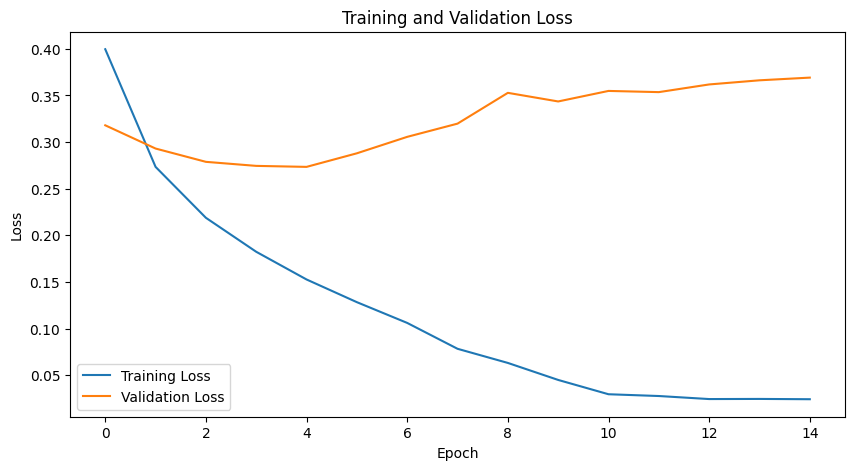

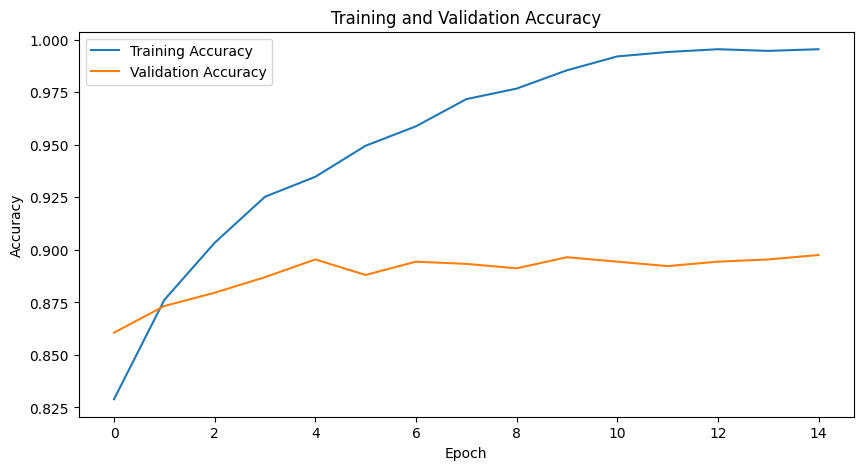

Epoch 1/100
----------


100%|██████████| 60/60 [00:11<00:00,  5.31it/s]

train Loss: 0.1299 Acc: 0.9522 CD Loss: 0.0000



100%|██████████| 15/15 [00:03<00:00,  4.91it/s]

val Loss: 0.2736 Acc: 0.8965 CD Loss: 0.0000
Epoch 2/100
----------



100%|██████████| 60/60 [00:11<00:00,  5.42it/s]

train Loss: 0.1001 Acc: 0.9630 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.15it/s]

val Loss: 0.2775 Acc: 0.8944 CD Loss: 0.0000
Epoch 3/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.50it/s]


train Loss: 0.0789 Acc: 0.9715 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.08it/s]

val Loss: 0.2940 Acc: 0.8944 CD Loss: 0.0000
Epoch 4/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.61it/s]


train Loss: 0.0572 Acc: 0.9807 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.17it/s]

val Loss: 0.3474 Acc: 0.8891 CD Loss: 0.0000
Epoch 5/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.48it/s]


train Loss: 0.0472 Acc: 0.9831 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.24it/s]


val Loss: 0.3524 Acc: 0.8891 CD Loss: 0.0000
Epoch 6/100
----------


100%|██████████| 60/60 [00:11<00:00,  5.21it/s]

train Loss: 0.0389 Acc: 0.9863 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.10it/s]

val Loss: 0.4249 Acc: 0.8986 CD Loss: 0.0000
Epoch 7/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.56it/s]

train Loss: 0.0328 Acc: 0.9913 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.12it/s]

val Loss: 0.3945 Acc: 0.8891 CD Loss: 0.0000
Epoch 8/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.53it/s]

train Loss: 0.0237 Acc: 0.9942 CD Loss: 0.0000



100%|██████████| 15/15 [00:03<00:00,  4.97it/s]

val Loss: 0.3814 Acc: 0.9007 CD Loss: 0.0000
Epoch 9/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.67it/s]


train Loss: 0.0167 Acc: 0.9955 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.01it/s]

val Loss: 0.4108 Acc: 0.9050 CD Loss: 0.0000
Epoch 10/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.71it/s]


train Loss: 0.0149 Acc: 0.9979 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.16it/s]


val Loss: 0.4204 Acc: 0.8997 CD Loss: 0.0000
Epoch 11/100
----------


100%|██████████| 60/60 [00:11<00:00,  5.23it/s]

train Loss: 0.0097 Acc: 0.9992 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.13it/s]


val Loss: 0.4114 Acc: 0.8997 CD Loss: 0.0000
Early stopping triggered after 11 epochs
Training complete in 2m 39s
Best val loss: 0.2736


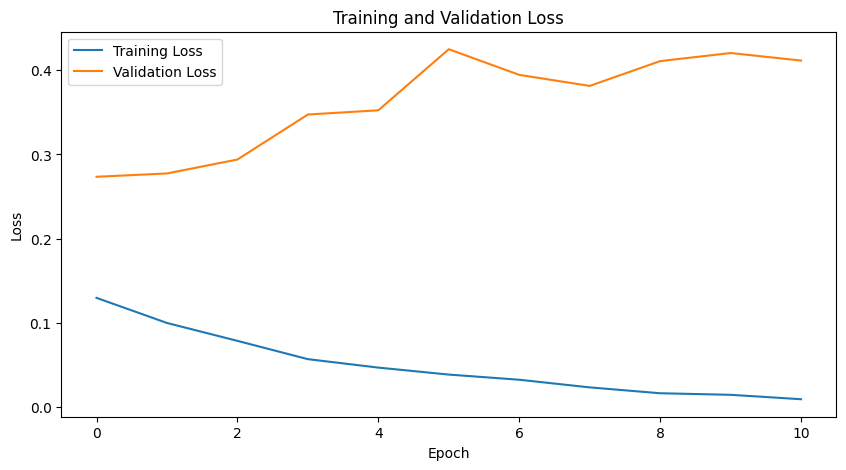

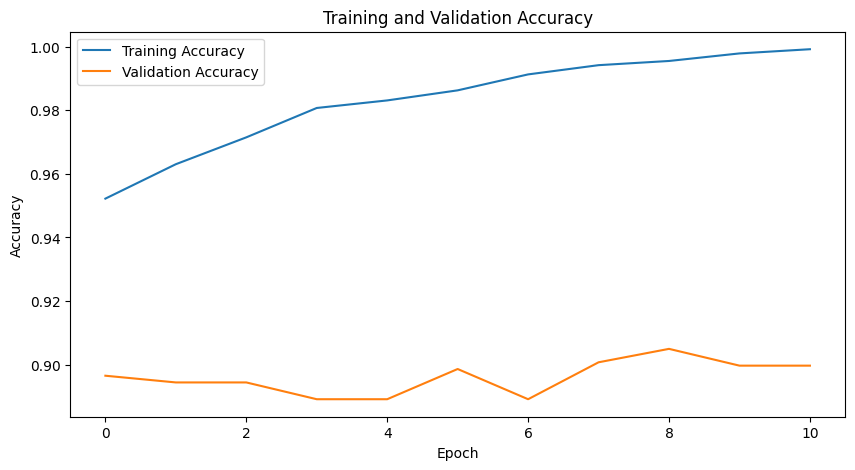

Epoch 1/100
----------


100%|██████████| 60/60 [00:11<00:00,  5.24it/s]

train Loss: 0.1006 Acc: 0.9633 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.20it/s]

val Loss: 0.2956 Acc: 0.8986 CD Loss: 0.0000
Epoch 2/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.51it/s]

train Loss: 0.0943 Acc: 0.9612 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.09it/s]

val Loss: 0.2986 Acc: 0.8828 CD Loss: 0.0000
Epoch 3/100
----------



100%|██████████| 60/60 [00:11<00:00,  5.41it/s]


train Loss: 0.0693 Acc: 0.9744 CD Loss: 0.0000


100%|██████████| 15/15 [00:03<00:00,  4.92it/s]

val Loss: 0.3442 Acc: 0.8923 CD Loss: 0.0000
Epoch 4/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.55it/s]

train Loss: 0.0461 Acc: 0.9850 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.02it/s]

val Loss: 0.3582 Acc: 0.8923 CD Loss: 0.0000
Epoch 5/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.57it/s]

train Loss: 0.0393 Acc: 0.9889 CD Loss: 0.0000



100%|██████████| 15/15 [00:03<00:00,  4.86it/s]


val Loss: 0.4429 Acc: 0.8965 CD Loss: 0.0000
Epoch 6/100
----------


100%|██████████| 60/60 [00:11<00:00,  5.23it/s]

train Loss: 0.0391 Acc: 0.9868 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.13it/s]

val Loss: 0.3707 Acc: 0.8955 CD Loss: 0.0000
Epoch 7/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.56it/s]

train Loss: 0.0309 Acc: 0.9916 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.17it/s]

val Loss: 0.3920 Acc: 0.8944 CD Loss: 0.0000
Epoch 8/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.63it/s]


train Loss: 0.0192 Acc: 0.9955 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]

val Loss: 0.3991 Acc: 0.8944 CD Loss: 0.0000
Epoch 9/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.58it/s]


train Loss: 0.0169 Acc: 0.9958 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.36it/s]

val Loss: 0.4064 Acc: 0.9018 CD Loss: 0.0000
Epoch 10/100
----------



100%|██████████| 60/60 [00:10<00:00,  5.63it/s]


train Loss: 0.0125 Acc: 0.9971 CD Loss: 0.0000


100%|██████████| 15/15 [00:02<00:00,  5.29it/s]


val Loss: 0.4729 Acc: 0.9007 CD Loss: 0.0000
Epoch 11/100
----------


100%|██████████| 60/60 [00:11<00:00,  5.23it/s]

train Loss: 0.0098 Acc: 0.9979 CD Loss: 0.0000



100%|██████████| 15/15 [00:02<00:00,  5.12it/s]


val Loss: 0.4390 Acc: 0.9029 CD Loss: 0.0000
Early stopping triggered after 11 epochs
Training complete in 2m 39s
Best val loss: 0.2956


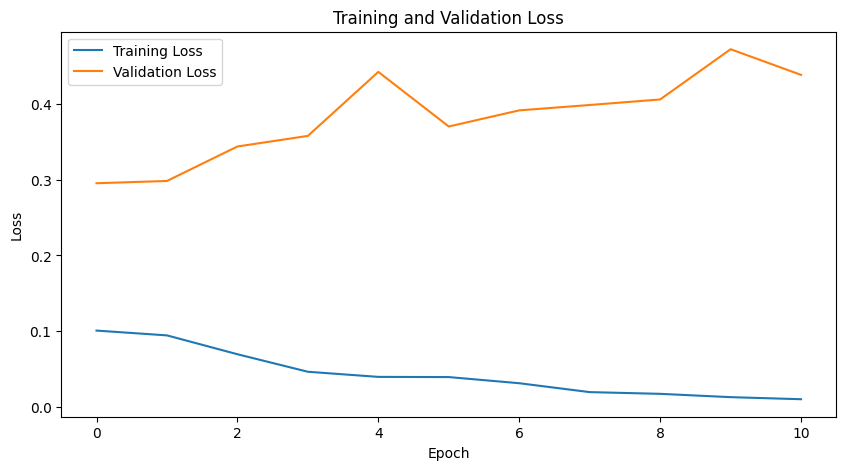

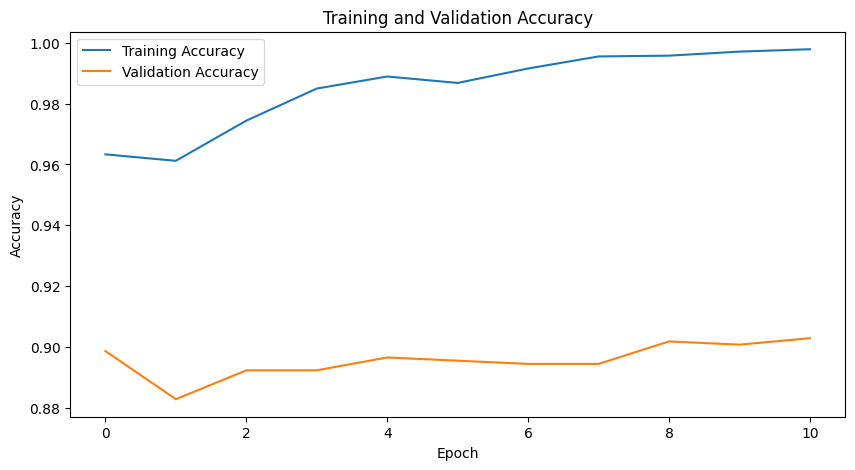

In [ ]:
wb_ratio = len(wb_no_patch)/len(complete_dataset)

not_two_ratio = 1 - wb_ratio
two_weight = 1/wb_ratio
not_two_weight = 1/ not_two_ratio
weights = np.asarray([not_two_weight, two_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())

mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64
        self.epochs = 100
        self.lr = 0.001
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0


regularizer_rate = args.regularizer_rate
num_epochs = args.epochs
seeds = [1, 11, 111]


torch.manual_seed(args.seed)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model.to(device)
#params_to_update = model.classifier.parameters()
params_to_update = model.parameters()





for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Initialize model, optimizer, and loss function
    params_to_update = model.parameters()
   #initialize_weights(model)
    optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)
    #criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_places_wb_isic_dist_{seed}" + "train.pt"))

### Extract Activations & Correlations

Computing activations and saving to activations.npy


<ipython-input-21-cb4c002e544b>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
<ipython-input-21-cb4c002e544b>:165: Constant

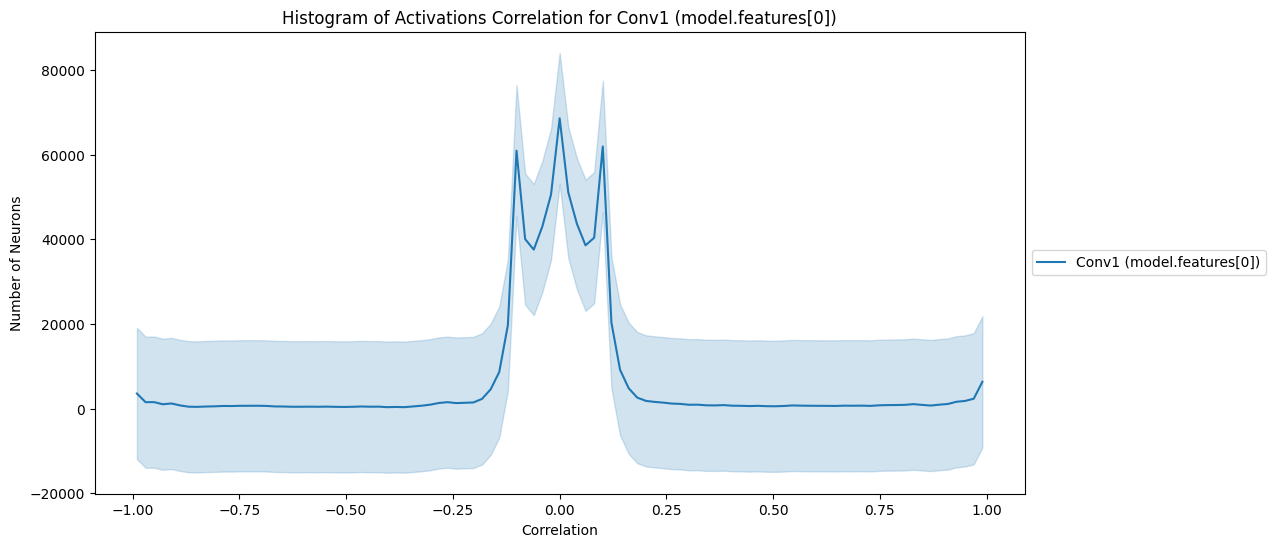

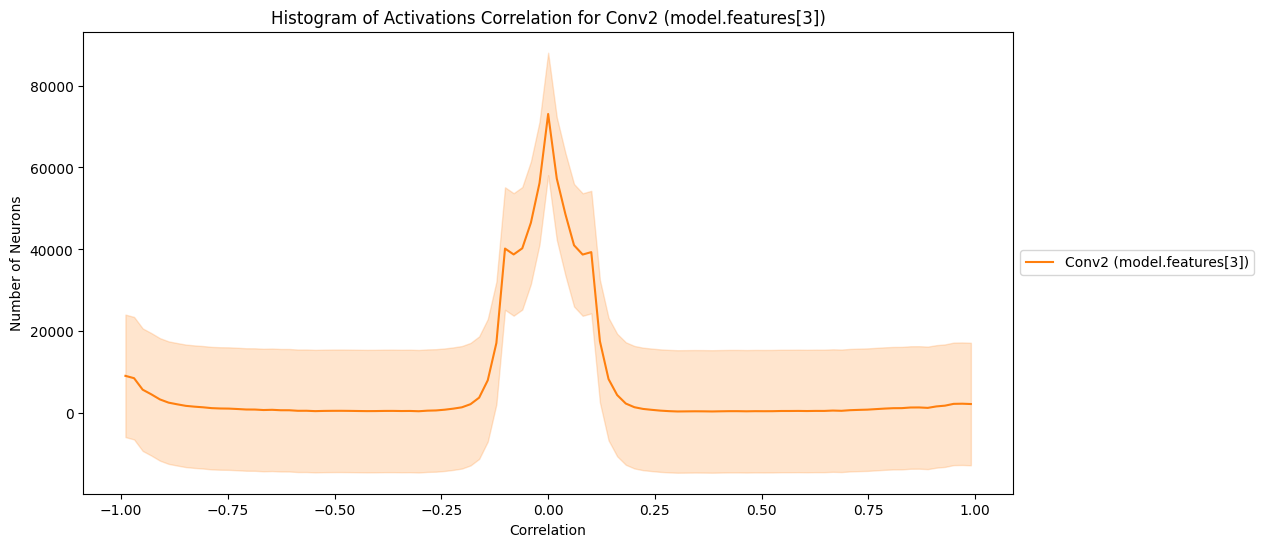

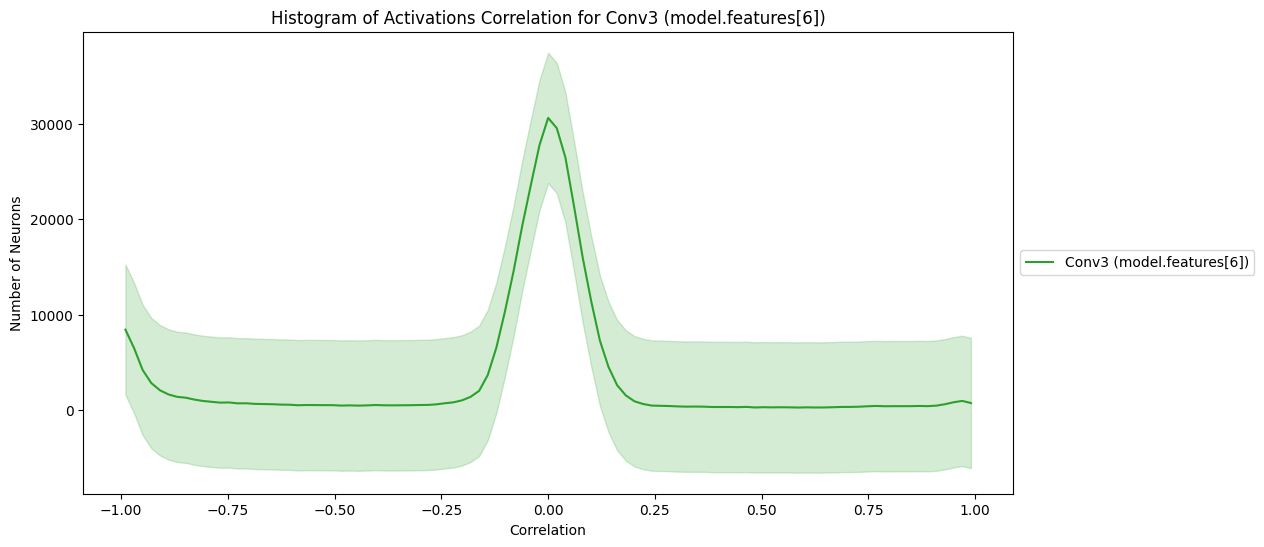

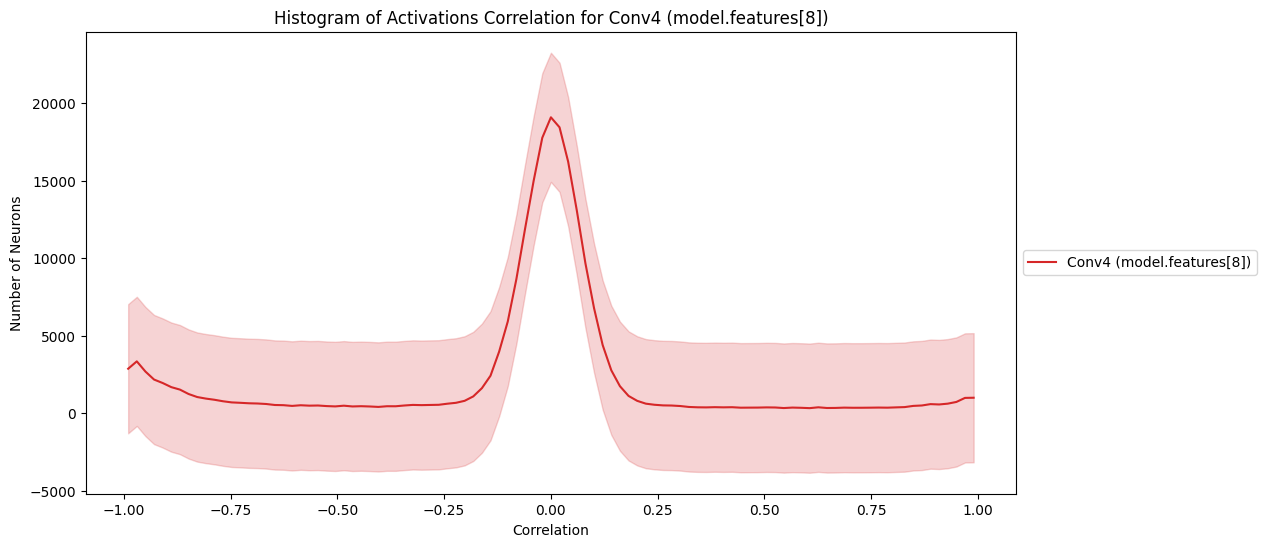

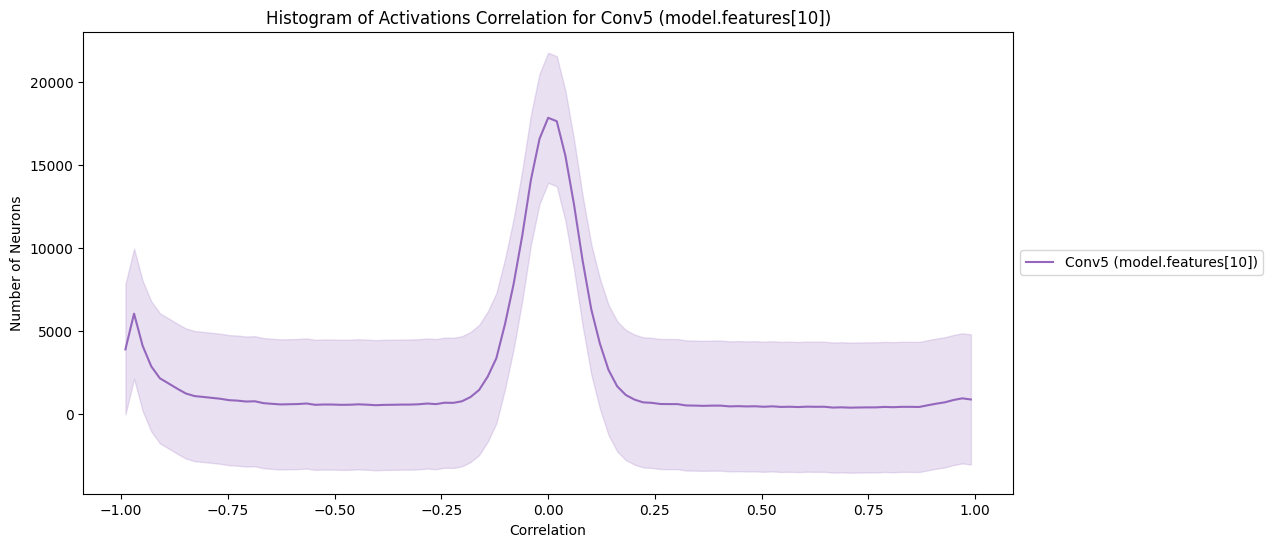

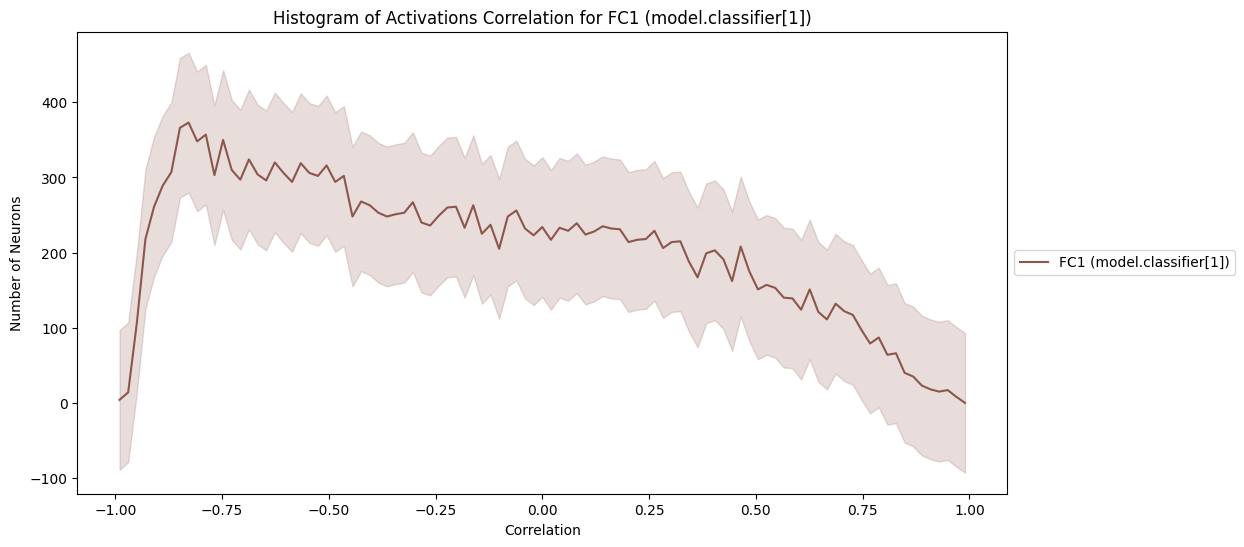

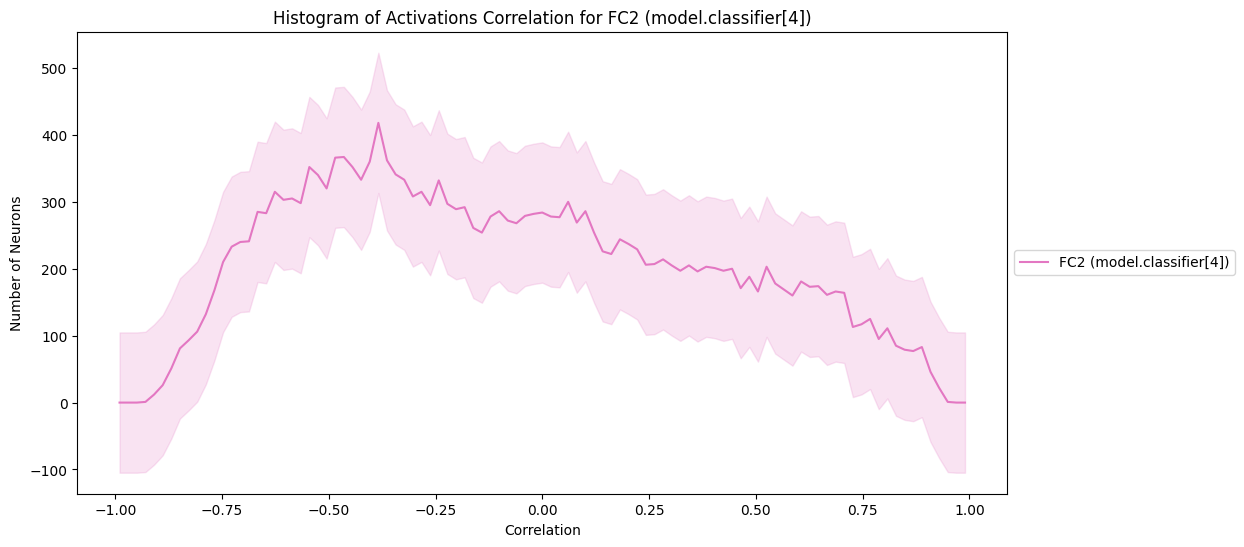

<ipython-input-21-cb4c002e544b>:203: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


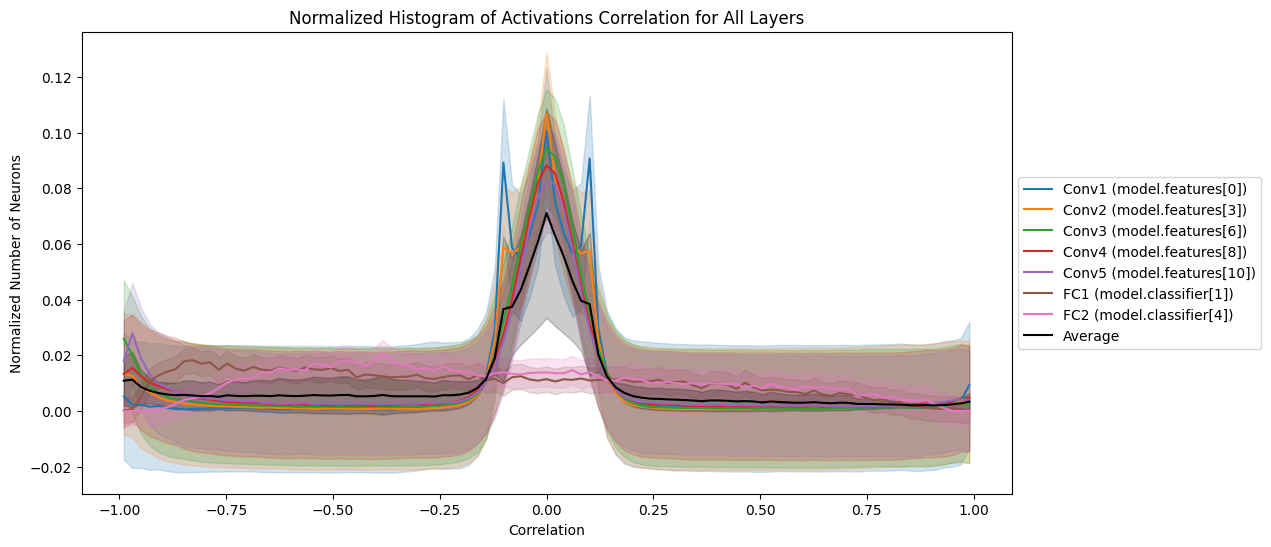

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

# Custom dataset class for loading images
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image

# Load and prepare the model
def load_model(model_path):
    model = models.alexnet(pretrained=False)
    model.classifier[-1] = torch.nn.Linear(4096, 2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            if layer < 13:  # Layer in model.features
                tensor = image_tensor
                for idx, layer_module in enumerate(model.features[:layer + 1]):
                    tensor = layer_module(tensor)
            else:  # Layer in model.classifier
                tensor = model.features(image_tensor)
                tensor = model.avgpool(tensor)
                tensor = torch.flatten(tensor, 1)
                for idx, layer_module in enumerate(model.classifier[:layer - 12]):
                    tensor = layer_module(tensor)

            activation = tensor.cpu().numpy()
            activations.append(activation)

    return activations

def process_images_in_folder(model, folder_path, layer, batch_size=5):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith(('.jpg', '.png'))]

    dataset = ImageDataset(image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    activations = preprocess_and_extract_activations(model, dataloader, layer)
    all_layer_activations.extend(activations)
    torch.cuda.empty_cache()
    gc.collect()

    return all_layer_activations


def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_isic/{filename}'
    np.save(drive_path, all_layer_activations)

def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_isic/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_isic/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        return load_activations(activations_file)

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    save_activations(all_layer_activations, activations_file)
    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 3, 6, 8, 10, 14, 17]
layer_names = {
    0: "Conv1 (model.features[0])",
    3: "Conv2 (model.features[3])",
    6: "Conv3 (model.features[6])",
    8: "Conv4 (model.features[8])",
    10: "Conv5 (model.features[10])",
    14: "FC1 (model.classifier[1])",
    17: "FC2 (model.classifier[4])"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']

patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_isic/test/wb_patch'
no_patch_waterbird_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/CUB/cub_isic/test/wb_no_patch'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_isic_dist_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_isic_dist_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/CUB/models/initial_classifier/alexnet_places_wb_isic_dist_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, patch_waterbird_folder_path, no_patch_waterbird_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


### Two sample T-test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations and inspect the structure
def load_activations(filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/CUB/activations_isic/{filename}'
    activations = np.load(drive_path, allow_pickle=True)
    print(f"Type of loaded activations: {type(activations)}")

    if isinstance(activations, np.ndarray) and activations.shape == ():
        # Check if the single element is the dictionary we need
        activations = activations.item()
        print(f"After extracting item, type: {type(activations)}")

    return activations

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(activations):
    t_test_results = {}
    for layer, data in activations.items():
        wp_activations = np.vstack(data['wp'])
        wo_activations = np.vstack(data['wo'])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        # Bonferroni Correction: Calculate the number of comparisons (neurons)
        num_comparisons = wp_activations.shape[1]  # Number of neurons
        adjusted_p_values = np.minimum(ttest_result.pvalue * num_comparisons, 1.0)  # Adjust p-values

        t_test_results[layer] = {
            'ttest': ttest_result,
            'raw_pvalue': ttest_result.pvalue,  # Store raw p-values
            'adjusted_pvalue': adjusted_p_values,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        raw_pvalue = results['raw_pvalue']
        adjusted_pvalue = results['adjusted_pvalue']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        below_or_equal_0_05_raw = np.mean(raw_pvalue <= 0.05) * 100
        below_or_equal_0_02_raw = np.mean(raw_pvalue <= 0.02) * 100
        below_or_equal_0_05_adj = np.mean(adjusted_pvalue <= 0.05) * 100
        below_or_equal_0_02_adj = np.mean(adjusted_pvalue <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test (before Bonferroni correction):")
        print(f"    Percentage of neurons with raw p-value <= 0.05: {below_or_equal_0_05_raw:.2f}%")
        print(f"    Percentage of neurons with raw p-value <= 0.02: {below_or_equal_0_02_raw:.2f}%")
        print("  T-Test (after Bonferroni correction):")
        print(f"    Percentage of neurons with adjusted p-value <= 0.05: {below_or_equal_0_05_adj:.2f}%")
        print(f"    Percentage of neurons with adjusted p-value <= 0.02: {below_or_equal_0_02_adj:.2f}%")
        print("-" * 50)



# Main execution
activations_file = 'activations.npy'
all_layer_activations = load_activations(activations_file)
t_test_results = perform_two_sample_t_tests(all_layer_activations)
print_t_test_results(t_test_results)

Type of loaded activations: <class 'numpy.ndarray'>
After extracting item, type: <class 'dict'>
Layer 0:
  WP Activations:
    Mean: -0.5063
  WO Activations:
    Mean: -0.5024
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 14.11%
    Percentage of neurons with raw p-value <= 0.02: 10.97%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 6.00%
    Percentage of neurons with adjusted p-value <= 0.02: 5.93%
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: -3.5950
  WO Activations:
    Mean: -2.8732
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 23.14%
    Percentage of neurons with raw p-value <= 0.02: 18.82%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 12.99%
    Percentage of neurons with adjusted p-value <= 0.02: 12.93%
---------------------------------------